<a href="https://colab.research.google.com/github/BorisBoiarchuk/MasterThesis/blob/main/Master_Thesis_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import gamma, gammaln
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
!git clone https://github.com/BorisBoiarchuk/MasterThesis.git


Cloning into 'MasterThesis'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 95 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 8.36 MiB | 7.87 MiB/s, done.
Resolving deltas: 100% (16/16), done.


Instuctions:

0) Open this notebook in Colab
1) Run the cell above, which imports all the necessary libraries and gets data from git-hub
2) Skip running (at least at first) the estimation of GARCH, TGARCH etc, as it will take some time.
3) Run Feature selection
4) Run risk-measures estimation and the following section for daily log-losses

For estimating GARCH, TGARCH, and other models I used the comibined.csv which is created in "Feature selection" section for weekly data and in the 1-st cell of the "Risk mearures estimation daily log-losses" section for the daily data. After that these sections can be used. I did most of them manually for control better understanding of what is happenning. Of course there are packages that do that more optimally.

Which is why the running time takes quite long, so I suggest skipping running these sections, as I already provide the data on the estimates in the vol folder.

Main language here is Python. In case of a need to switch to R language go to Runtime -> Change runtime type and select R language.


# **Feature selection**

In [ ]:
data = pd.read_csv('MasterThesis/data/SX7E.csv')[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=False,inplace=True)
log_returns = (np.log(data[['Close']] / data[['Close']].shift(-1)).dropna())*1000


VSTOXX = pd.read_csv('MasterThesis/data/VSTOXX.csv')
VSTOXX['Date'] = pd.to_datetime(VSTOXX['Date'])
VSTOXX.set_index('Date', inplace=True)

VIX = pd.read_csv('MasterThesis/data/VIX_History.csv')[['DATE', 'CLOSE']]
VIX.columns = ['Date', 'VIX']
VIX['Date'] = pd.to_datetime(VIX['Date'])
VIX.set_index('Date', inplace=True)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     7385.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:13:26   Log-Likelihood:                -39190.
No. Observations:                6878   AIC:                         7.838e+04
Df Residuals:                    6876   BIC:                         7.840e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.9607      1.741     37.318      0.0

<Figure size 1200x500 with 0 Axes>

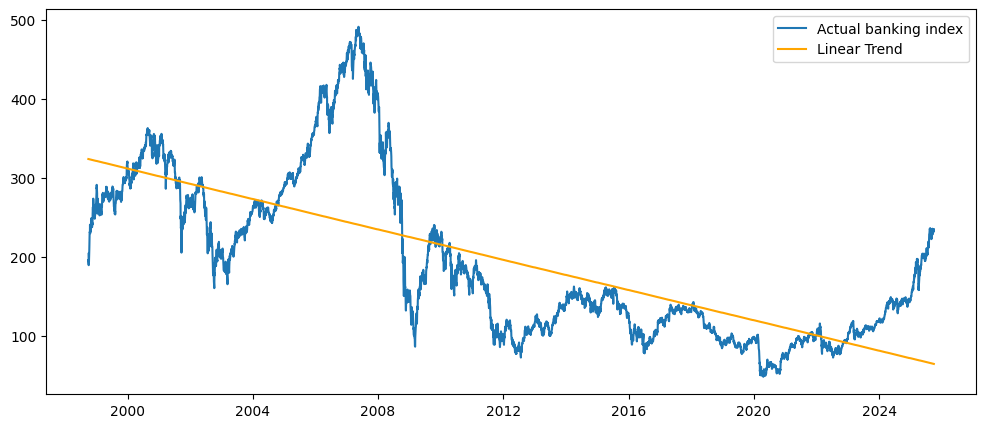

In [ ]:
plt.figure(figsize=(12,5))
mod = sm.OLS(data['Close'].to_numpy(),sm.add_constant(np.arange(1,len(data['Close'])+1))).fit()
print(mod.summary())
y_hat = mod.fittedvalues
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Close'], label='Actual banking index')
plt.plot(data.index, y_hat, label='Linear Trend', color='orange')
plt.legend()
plt.show()

In [ ]:
fsi = pd.read_csv('MasterThesis/data/fsi.csv')[['Date', 'Other advanced economies']]
fsi.columns = ['Date', 'FSI']
fsi['Date'] = pd.to_datetime(fsi['Date'])
fsi.set_index('Date', inplace=True)
weekly_fsi = fsi['FSI'].groupby(pd.Grouper(freq="W-FRI")).mean()

euribor1m = pd.read_excel('MasterThesis/data/EURIBOR1mRef_Eikon.xlsx', skiprows=1)
euribor1m.columns = ['Date', 'Euribor1m']
euribor1m['Date'] = pd.to_datetime(euribor1m['Date'])
euribor1m.set_index('Date', inplace=True)

euribor3m = pd.read_excel('MasterThesis/data/EURIBOR3mRef_Eikon.xlsx', skiprows=1)
euribor3m.columns = ['Date', 'Euribor3m']
euribor3m['Date'] = pd.to_datetime(euribor3m['Date'])
euribor3m.set_index('Date', inplace=True)

euribor6m = pd.read_excel('MasterThesis/data/EURIBOR6mRef_Eikon.xlsx', skiprows=1)
euribor6m.columns = ['Date', 'Euribor6m']
euribor6m['Date'] = pd.to_datetime(euribor6m['Date'])
euribor6m.set_index('Date', inplace=True)

euribor12m = pd.read_excel('MasterThesis/data/EURIBOR12mRef_Eikon.xlsx', skiprows=1)
euribor12m.columns = ['Date', 'Euribor12m']
euribor12m['Date'] = pd.to_datetime(euribor12m['Date'])
euribor12m.set_index('Date', inplace=True)

Euribor = pd.concat([euribor1m, euribor3m, euribor6m, euribor12m], axis=1)
Euribor.sort_index(inplace=True)
Euribor = Euribor[2400:]

weekly_Euribor6m = Euribor['Euribor6m'].groupby(pd.Grouper(freq="W-FRI")).mean()


In [ ]:
EURCHF = pd.read_excel('MasterThesis/data/EURCHF.xlsx', skiprows=1)
EURCHF.columns = ['Date', 'EURCHF']
EURCHF['Date'] = pd.to_datetime(EURCHF['Date'])
EURCHF.set_index('Date', inplace=True)


EURGBP = pd.read_excel('MasterThesis/data/EURGBP.xlsx', skiprows=1)
EURGBP.columns = ['Date', 'EURGBP']
EURGBP['Date'] = pd.to_datetime(EURGBP['Date'])
EURGBP.set_index('Date', inplace=True)


EURUSD = pd.read_excel('MasterThesis/data/EURUSD.xlsx', skiprows=1)
EURUSD.columns = ['Date', 'EURUSD']
EURUSD['Date'] = pd.to_datetime(EURUSD['Date'])
EURUSD.set_index('Date', inplace=True)


EURJPY = pd.read_excel('MasterThesis/data/EURJPY.xlsx', skiprows=1)
EURJPY.columns = ['Date', 'EURJPY']
EURJPY['Date'] = pd.to_datetime(EURJPY['Date'])
EURJPY.set_index('Date', inplace=True)


iBoxx = pd.read_excel('MasterThesis/data/iBoxx_EUR_overall_Ref_Eikon.xlsx', skiprows=1)
iBoxx.columns = ['Date', 'iBoxx']
iBoxx['Date'] = pd.to_datetime(iBoxx['Date'])
iBoxx.set_index('Date', inplace=True)

other_exgogenous = pd.concat([EURCHF, EURGBP, EURUSD, EURJPY, iBoxx], axis=1)
other_exgogenous.columns = ['EURCHF', 'EURGBP', 'EURUSD', 'EURJPY', 'iBoxx']
other_exgogenous = other_exgogenous[1040:8000]
other_exgogenous.sort_index(ascending=False, inplace=True)
other_exgogenous = (np.log(other_exgogenous/ other_exgogenous.shift(-1)))*1000
other_exgogenous

EURCHF     EURGBP     EURUSD     EURJPY     iBoxx
Date                                                           
2025-06-26 -2.027857  -1.407790   3.424954  -2.483298  0.511373
2025-06-25  3.631707   0.820970   4.383898   6.695329 -1.362198
2025-06-24 -6.400022  -4.098126   2.760526  -5.690928 -0.018968
2025-06-23 -2.018164  -1.167815   4.675738   5.274868  1.072014
2025-06-20  4.146957   4.210533   2.433091   6.558182  0.019430
...              ...        ...        ...        ...       ...
1999-01-06  1.979464 -12.739026 -12.491607   8.038321  0.325142
1999-01-05  0.123847  -3.369843  -5.426962 -17.297646  0.334201
1999-01-04       NaN        NaN        NaN        NaN  5.049461
1999-01-01       NaN        NaN        NaN        NaN  0.151988
1998-12-31       NaN        NaN        NaN        NaN       NaN

[6960 rows x 5 columns]

In [ ]:
weekly_log_ret = log_returns['Close'].groupby(pd.Grouper(freq="W-FRI")).sum()
weekly_VSTOXX = VSTOXX['VSTOXX'].groupby(pd.Grouper(freq="W-FRI")).mean()
weekly_VIX = VIX['VIX'].groupby(pd.Grouper(freq="W-FRI")).mean()
weekly_other_exgogenous = other_exgogenous.groupby(pd.Grouper(freq="W-FRI")).sum()


combined = pd.merge(weekly_log_ret, weekly_VSTOXX, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_VIX, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_other_exgogenous, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_Euribor6m, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_fsi, how='left', on='Date')
combined.dropna(inplace=True)
combined.columns = ['Log Return', 'VSTOXX', 'VIX', 'EURCHF', 'EURGBP', 'EURUSD', 'EURJPY', 'iBoxx', 'Euribor6m', 'FSI']

In [ ]:
H=len(combined)
T=int(round(H*0.6,0))

In [ ]:
combined.to_csv('combined.csv')

In [ ]:
combined

Log Return    VSTOXX      VIX    EURCHF     EURGBP     EURUSD  \
Date                                                                        
2000-01-07  -29.024199  31.08464  25.0160  3.486059   6.550067  21.514657   
2000-01-14  -10.837417  27.49348  21.6840  2.916449 -12.014562 -16.067750   
2000-01-21  -31.962129  27.57092  21.4475 -2.171015 -14.610650  -3.561892   
2000-01-28  -25.020799  29.04040  23.9600 -0.559024 -15.159295 -34.691388   
2000-02-04   -1.305438  29.82912  23.0140 -2.114692  24.437460   8.175825   
...                ...       ...      ...       ...        ...        ...   
2025-05-30   11.286576  19.13844  19.3180  0.535992   4.634314  -1.497072   
2025-06-06   14.004864  18.46450  17.7820  3.637146  -1.186240   4.133509   
2025-06-13  -30.427403  18.74312  18.0420 -0.213584   9.450750  13.771681   
2025-06-20   -4.756613  22.38068  20.7280  6.493875   7.380107  -2.600331   
2025-06-27   21.973393  19.23820  17.3960 -6.814336  -5.852762  15.245117   

               EURJPY     iBoxx  Euribor6m     FSI  
Date                                                
2000-01-07  49.759626 -1.858261     3.5448  0.4246  
2000-01-14 -11.509316 -3.092089     3.5388  0.3348  
2000-01-21 -13.628671 -1.095736     3.5292  0.1855  
2000-01-28 -13.145550 -1.133076     3.5872  0.0612  
2000-02-04   9.162992  5.692624     3.6898  0.0648  
...               ...       ...        ...     ...  
2025-05-30   8.850159  4.891024     2.0624 -0.3504  
2025-06-06   9.500102 -1.841617     2.0566 -0.4232  
2025-06-13   8.629847  1.408366     2.0508 -0.4644  
2025-06-20  11.114545  0.364367     2.0542 -0.2890  
2025-06-27   3.795971  0.202222     2.0372 -0.4466  

[1330 rows x 10 columns]

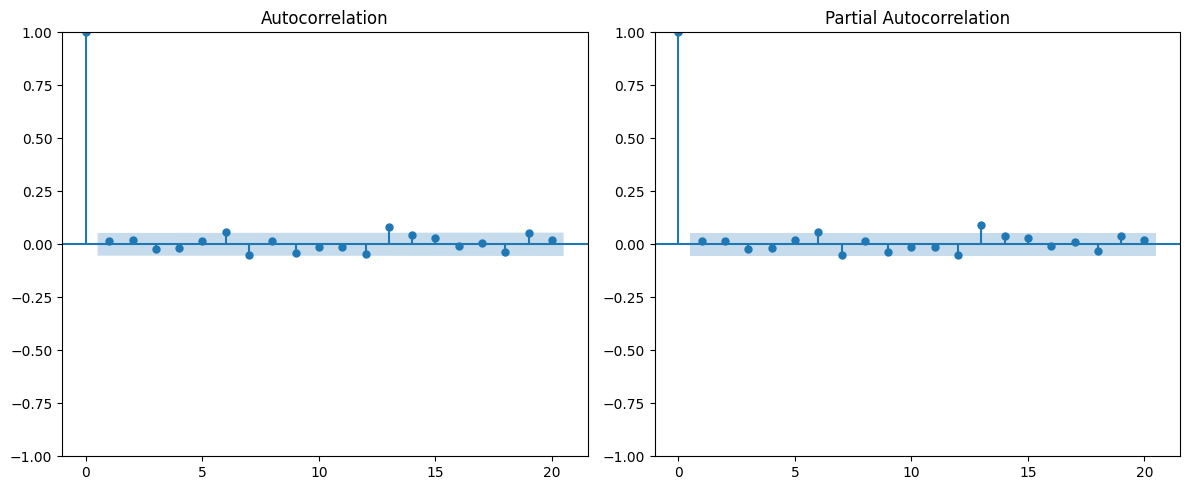

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(-combined['Log Return'], lags=20, ax=plt.gca())

plt.subplot(1, 2, 2)
plot_pacf(-combined['Log Return'], lags=20, ax=plt.gca(), method="ywm")  # PACF plot (Yule-Walker method)

plt.tight_layout()
plt.show()

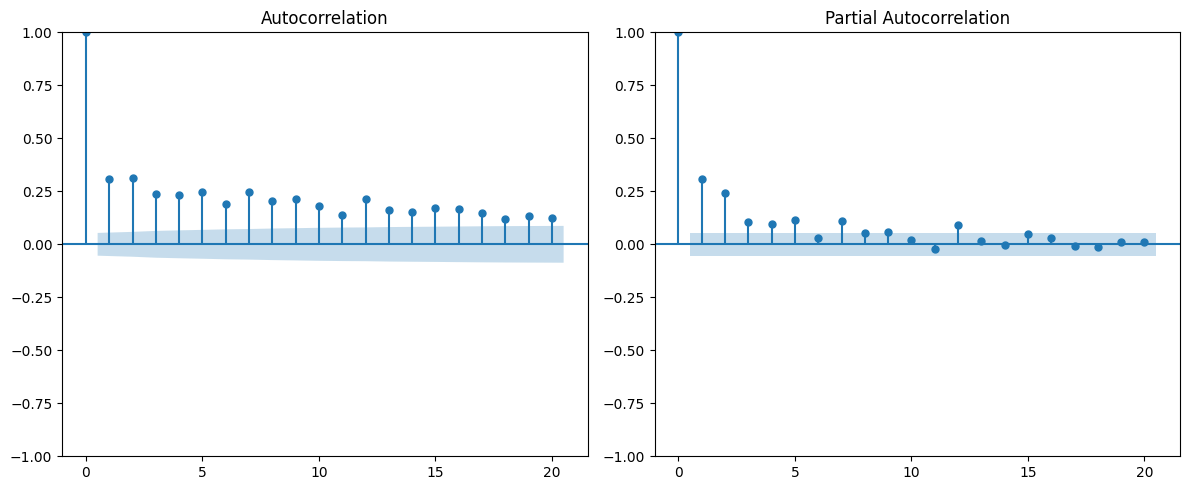

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(abs(-combined['Log Return']), lags=20, ax=plt.gca())

plt.subplot(1, 2, 2)
plot_pacf(abs(-combined['Log Return']), lags=20, ax=plt.gca(), method="ywm")  # PACF plot (Yule-Walker method)

plt.tight_layout()
plt.show()

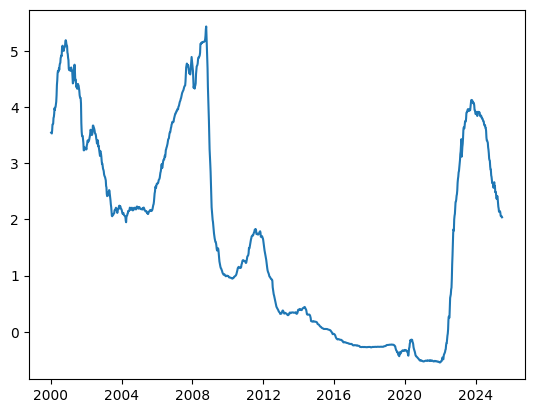

In [ ]:
plt.plot(combined['Euribor6m'])

In [ ]:


# regression model
vol = pd.read_csv('MasterThesis/data/vol/vol_TGARCH.csv')
vol.columns = ['vol']
vol['Date'] = pd.to_datetime(combined.index)
vol.set_index('Date', inplace=True)


XY = pd.merge(combined, vol, how='left', on='Date')
X = XY[['VSTOXX','Euribor6m','FSI']]

Y = XY[['vol']]

X = sm.add_constant(X)

split_idx = int(0.6 * X.shape[0])

X_train = X[:split_idx]
X_test  = X[split_idx:]
Y_train = Y[:split_idx]
Y_test  = Y[split_idx:]




LS = sm.OLS(Y_train,X_train).fit()
forecasted = LS.predict(X_test)
test_mse = np.mean((Y_test.to_numpy() - forecasted.to_numpy())**2)

print(f'The test MSE is: {np.round(test_mse,2)}')
print(LS.summary())

The test MSE is: 460.52
                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1075.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          5.43e-279
Time:                        13:16:27   Log-Likelihood:                -3010.9
No. Observations:                 798   AIC:                             6030.
Df Residuals:                     794   BIC:                             6048.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.2229      1

In [ ]:
corr_matrix = X.corr()
print(np.round(corr_matrix,3))

           const  VSTOXX  Euribor6m    FSI
const        NaN     NaN        NaN    NaN
VSTOXX       NaN   1.000      0.159  0.780
Euribor6m    NaN   0.159      1.000  0.364
FSI          NaN   0.780      0.364  1.000


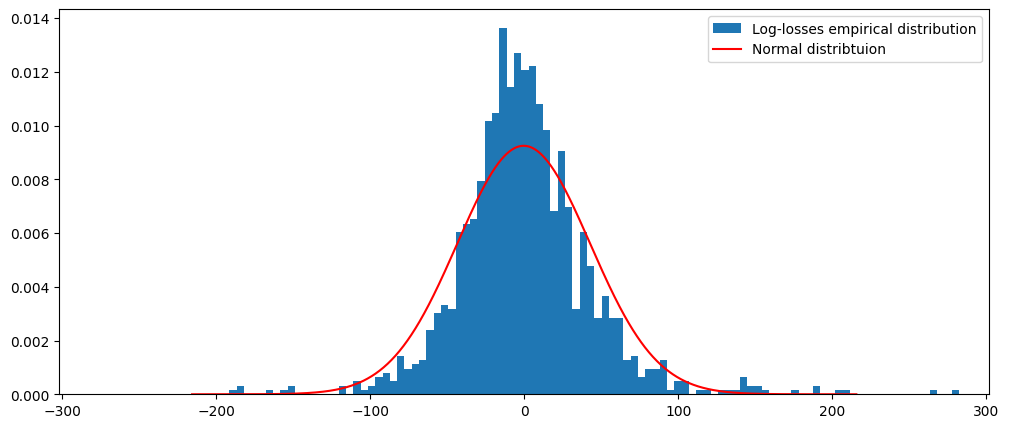

In [ ]:
mu = combined['Log Return'].mean()
s_dev = combined['Log Return'].std()
x_ax = np.linspace(-5*s_dev, 5*s_dev, 1000)


plt.figure(figsize=(12, 5))
plt.hist(-combined['Log Return'], bins = 100, density = True, label="Log-losses empirical distribution")
plt.plot(x_ax, stats.norm.pdf(x_ax, mu, s_dev), color='r', label="Normal distribtuion")
plt.xlim(-7*s_dev, 7*s_dev)
plt.legend()
plt.show()

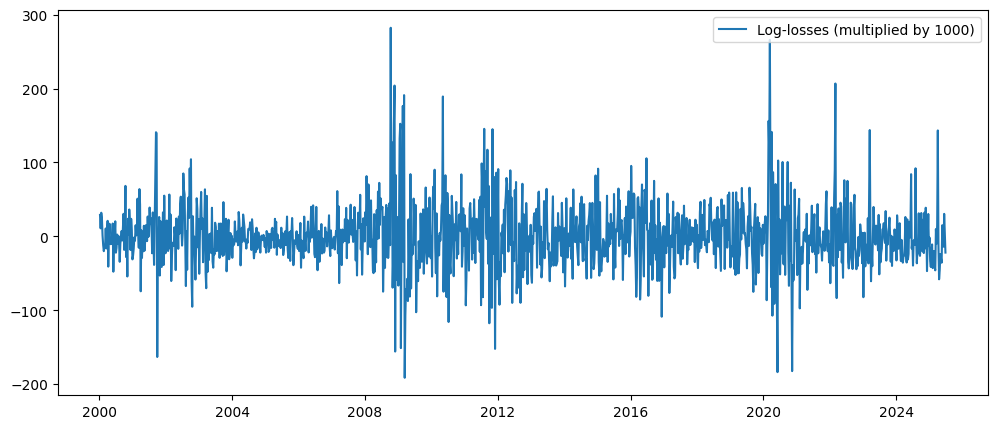

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(-combined['Log Return'], label="Log-losses (multiplied by 1000)")
plt.legend(loc="upper right")
plt.show()

#**R Log-GARCH-X Estimation (skip)**

**Switch to R**

In [ ]:
install.packages("lgarch")

In [ ]:
library(lgarch)
library(zoo)

Rolling window

In [ ]:
###############################################
###############################################

df <- read.csv("combined.csv")

df <- df[order(df$Date), ]   # makes sure ascending (oldest to newest)

y  <- zoo(df$Log.Return,  order.by = df$Date)

X_orig = list()
X = list()

exog <- df[, c("Date","FSI", "Euribor6m")]

for (i in 2:ncol(exog)) {
  value <- zoo(exog[, i], order.by = exog$Date)
  X_orig[[i-1]] <- value
  X[[i-1]] <- glag(value, 1)
}
X <- do.call(cbind, X)
colnames(X) <- paste0(names(exog)[-1], "_1")

nvar = ncol(exog)-1


H <- length(y)
S <- round(H*0.6)

vol_Log_GARCHX <- numeric(H)

keep <- complete.cases(y, X)
mu_hat <- mean(as.numeric(y[keep][1:S])) # mean of log-returns is almost negligible,
# so no benefit of estimating it via ML together with other parameters,
# so we will just demean the series for simplicity

par_names <- c("mu", "w", "a1", "b1", paste0("lam_", colnames(X))) #### comment last term as well to switch off X + add )
par_store <- matrix(NA_real_, nrow = H, ncol = length(par_names))
colnames(par_store) <- par_names

y_train <- y[keep][1:S] - mu_hat
X_train <- X[keep, ][1:S]

fit <- lgarch(as.numeric(y_train),
              arch = 1, garch = 1,
              xreg = as.matrix(X_train), ### comment to switch off X
              method = "ml")
cf   <- coef(fit)                 # parameter vector
w    <- cf[1]                     # intercept
a1   <- cf[2]                     # alpha_1
b1   <- cf[3]                     # beta_1
lam  <- cf[-(1:3)]                # lambda's for x_{t-1}; should match colnames(X)

vol_Log_GARCHX[1:S] <- fitted(fit)

par_store[S, ] <- c(mu_hat, w, a1, b1, lam[1:nvar]) #### comment last term as well to switch off X + add )
yT   <- as.numeric(tail(y_train, 1))
hT   <- 2 * log(as.numeric(tail(fitted(fit), 1)))
xT_vec <- sapply(X_orig, function(x) as.numeric(tail(x[keep][1:S], 1)))

h_T1  <- w + a1 * log(yT^2) + b1 * hT + sum(lam[1:nvar] * xT_vec) #### comment last term as well to switch off X
vol_Log_GARCHX[S+1] <- exp(0.5 * h_T1)

for (t in (S+1):(H-1)) {
mu_hat <- mean(as.numeric(y[keep][(t - S + 1):t]))
y_train <- y[keep][(t - S + 1):t] - mu_hat
X_train <- X[keep, ][(t - S + 1):t]

fit <- lgarch(as.numeric(y_train),
              arch = 1, garch = 1,
              xreg = as.matrix(X_train), ### comment to switch off X
              method = "ml")
cf   <- coef(fit)                 # parameter vector
w    <- cf[1]                     # intercept
a1   <- cf[2]                     # alpha_1
b1   <- cf[3]                     # beta_1
lam  <- cf[-(1:3)]                # lambda's for x_{t-1}; should match colnames(X)

par_store[t, ] <- c(mu_hat, w, a1, b1, lam[1:nvar]) #### comment last term as well to switch off X + add )

yT   <- as.numeric(tail(y_train, 1))
hT   <- 2 * log(as.numeric(tail(fitted(fit), 1)))
xT_vec <- sapply(X_orig, function(x) as.numeric(tail(x[keep][(t - S + 1):t], 1)))
h_T1  <- w + a1 * log(yT^2) + b1 * hT + sum(lam[1:nvar] * xT_vec) #### comment last term as well to switch off X
vol_Log_GARCHX[t+1] <- exp(0.5 * h_T1)
}


In [ ]:
sig_zoo <- zoo(vol_Log_GARCHX, order.by = index(y)[keep])
out <- data.frame(
  Date       = as.Date(index(sig_zoo)),
  sigma_hat  = as.numeric(sig_zoo),
  par_store[keep, , drop = FALSE]
)

write.csv(out, "vol_Log_GARCHX_FSI_Euribor.csv", row.names = FALSE)

# **R Log-TGARCH-X Estimation (skip)**

In [ ]:
install.packages("lgarch")
library(lgarch)
library(zoo)

In [ ]:
df <- read.csv("combined.csv")
df$loss_pos <- ifelse(df$Log.Return < 0, log(df$Log.Return^2), 0) # mu is small, so for simplicity we will the return being negative as a condition for the indicator
df <- df[order(df$Date), ]   # makes sure ascending (oldest to newest)

In [ ]:




y  <- zoo(df$Log.Return,  order.by = df$Date)
X_orig = list()
X = list()

exog <- df[, c("Date","FSI","Euribor6m", "loss_pos")]

for (i in 2:ncol(exog)) {
  value <- zoo(exog[, i], order.by = exog$Date)
  X_orig[[i-1]] <- value
  X[[i-1]] <- glag(value, 1)
}
X <- do.call(cbind, X)
colnames(X) <- paste0(names(exog)[-1], "_1")

nvar = ncol(exog)-1


H <- length(y)
S <- round(H*0.6)

vol_Log_GARCHX <- numeric(H)

keep <- complete.cases(y, X)
mu_hat <- mean(as.numeric(y[keep][1:S]))
y_train <- y[keep][1:S] - mu_hat
X_train <- X[keep, ][1:S]

par_names <- c("mu", "w", "a1", "b1", paste0("lam_", colnames(X))) #### no need to repeat commenting out for TGARCH, as we always use the leverage term as X
par_store <- matrix(NA_real_, nrow = H, ncol = length(par_names))
colnames(par_store) <- par_names


fit <- lgarch(as.numeric(y_train),
              arch = 1, garch = 1,
              xreg = as.matrix(X_train),
              method = "ml")
cf   <- coef(fit)                 # parameter vector
w    <- cf[1]                     # intercept
a1   <- cf[2]                     # alpha_1
b1   <- cf[3]                     # beta_1
lam  <- cf[-(1:3)]                # lambda's for x_{t-1}; should match colnames(X)

vol_Log_GARCHX[1:S] <- fitted(fit)

par_store[S, ] <- c(mu_hat, w, a1, b1, lam[1:nvar]) ####

yT   <- as.numeric(tail(y_train, 1))
hT   <- 2 * log(as.numeric(tail(fitted(fit), 1)))
xT_vec <- sapply(X_orig, function(x) as.numeric(tail(x[keep][1:S], 1)))

h_T1  <- w + a1 * log(yT^2) + b1 * hT + sum(lam[1:nvar] * xT_vec) ####
vol_Log_GARCHX[S+1] <- exp(0.5 * h_T1)

for (t in (S+1):(H-1)) {
mu_hat <- mean(as.numeric(y[keep][(t - S + 1):t]))
y_train <- y[keep][(t - S + 1):t] - mu_hat
X_train <- X[keep, ][(t - S + 1):t]

fit <- lgarch(as.numeric(y_train),
              arch = 1, garch = 1,
              xreg = as.matrix(X_train),
              method = "ml")
cf   <- coef(fit)                 # parameter vector
w    <- cf[1]                     # intercept
a1   <- cf[2]                     # alpha_1
b1   <- cf[3]                     # beta_1
lam  <- cf[-(1:3)]                # lambda's for x_{t-1}; should match colnames(X)

par_store[t, ] <- c(mu_hat, w, a1, b1, lam[1:nvar]) ####

yT   <- as.numeric(tail(y_train, 1))
hT   <- 2 * log(as.numeric(tail(fitted(fit), 1)))
xT_vec <- sapply(X_orig, function(x) as.numeric(tail(x[keep][(t - S + 1):t], 1)))
h_T1  <- w + a1 * log(yT^2) + b1 * hT + sum(lam[1:nvar] * xT_vec) ####
vol_Log_GARCHX[t+1] <- exp(0.5 * h_T1)
}

In [ ]:
sig_zoo <- zoo(vol_Log_GARCHX, order.by = index(y)[keep])
out <- data.frame(
  Date       = as.Date(index(sig_zoo)),
  sigma_hat  = as.numeric(sig_zoo),
  par_store[keep, , drop = FALSE]
)

write.csv(out, "vol_Log_TGARCHX_FSI_Euribor.csv", row.names = FALSE)

**End of R**

# **GARCH-X python Estimation (skip)**

In [ ]:
y = combined['Log Return'].to_numpy()
X = combined[['FSI']].to_numpy()

def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu, x_t_lagged, gamma):
  omega, alpha, beta = theta
  return omega + alpha * (y_t_lagged - mu) ** 2 + beta * variance_t_lagged + x_t_lagged @ gamma

def total_neg_loglik(parameters, y, X, variance_0):
  omega, alpha, beta, d, mu = parameters[:5]
  gamma = parameters[5:]
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln takes to much time

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta), mu, X[t-1], gamma)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll



def garch_x(y, X, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0], np.zeros(X.shape[1])))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (2.01, 200.0), (None, None)] + [(None, None)] * X.shape[1]
  lc = LinearConstraint(np.r_[0, 1, 1, 0, 0, np.zeros(X.shape[1])], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, X, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, d_hat, mu_hat, *gamma_hat = res.x # * means rest coefs are gamma

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}, gamma={np.array(gamma_hat)}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat), mu_hat, X[t-1], gamma_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_GARCHX = np.empty(len(y))
parameters_GARCHX = np.empty((int(H-T),int(5+X.shape[1])))

vol_GARCHX[:T+1], parameters_GARCHX[0] = garch_x(y[:T],X[:T],variance_0)
for t in range(T+1,H):  #so far runs 17 mins
  print(t)
  vol, parameters_GARCHX[t-T] = garch_x(y[t-T:t], X[t-T:t], vol_GARCHX[t-T-1] ** 2, parameters_GARCHX[t-T-1])
  vol_GARCHX[t] = vol[-1]

# **GARCH Estimation (skip)**

In [ ]:
y = combined['Log Return'].to_numpy()


def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu):
  omega, alpha, beta = theta
  return omega + alpha * (y_t_lagged - mu) ** 2 + beta * variance_t_lagged

def total_neg_loglik(parameters, y, variance_0):
  omega, alpha, beta, d, mu = parameters
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln computation takes to much time inside the loop

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta), mu)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll


def garch(y, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0]))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (2.01, 200.0), (None, None)]
  lc = LinearConstraint(np.r_[0, 1, 1, 0, 0], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, d_hat, mu_hat = res.x

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat), mu_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_GARCH = np.empty(len(y))
parameters_GARCH = np.empty((int(H-T),int(5)))

vol_GARCH[:T+1], parameters_GARCH[0] = garch(y[:T],variance_0)
for t in range(T+1,H):
  print(t)
  vol, parameters_GARCH[t-T] = garch(y[t-T:t], vol_GARCH[t-T-1] ** 2, parameters_GARCH[t-T-1])
  vol_GARCH[t] = vol[-1]

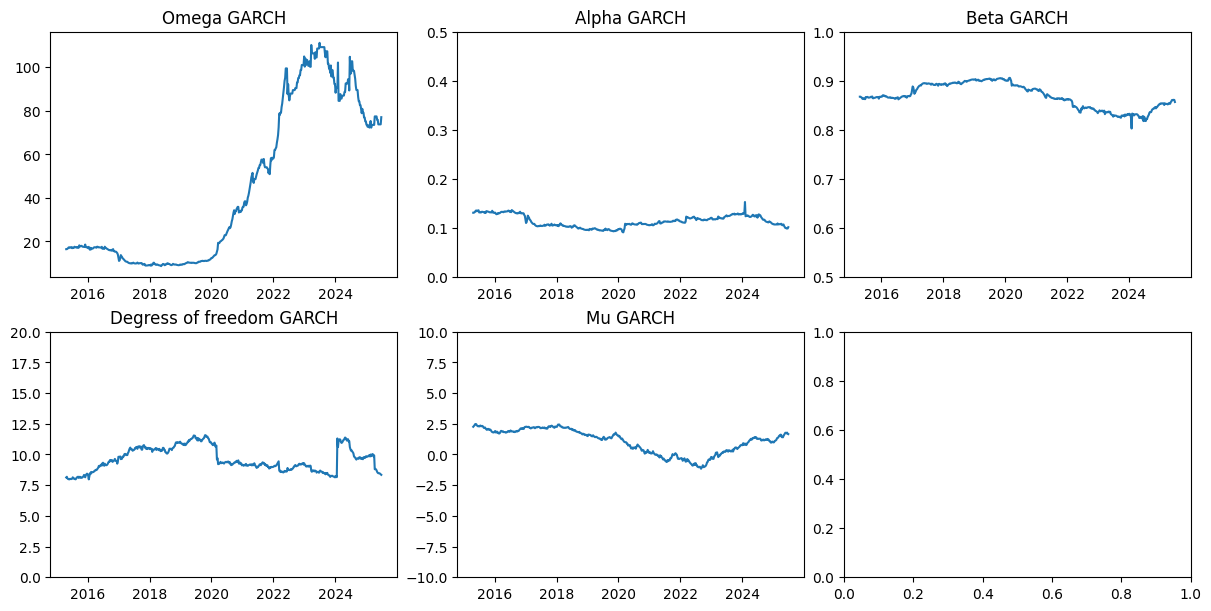

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_GARCH[:,0]);      axs[0, 0].set_title('Omega GARCH')
axs[0,1].plot(combined[T:H].index, parameters_GARCH[:,1]);      axs[0, 1].set_title('Alpha GARCH'); axs[0, 1].set_ylim(0, 0.5)
axs[0,2].plot(combined[T:H].index, parameters_GARCH[:,2]);      axs[0, 2].set_title('Beta GARCH'); axs[0, 2].set_ylim(0.5, 1)
axs[1,0].plot(combined[T:H].index, parameters_GARCH[:,3]);      axs[1, 0].set_title('Degress of freedom GARCH'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_GARCH[:,4]);      axs[1, 1].set_title('Mu GARCH'); axs[1, 1].set_ylim(-10, 10)
plt.show()


# **TGARCH-X Estimation (skip)**

In [ ]:
y = combined['Log Return'].to_numpy()
X = combined[['FSI','VSTOXX']].to_numpy()

def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu, x_t_lagged, gamma):
  omega, alpha, beta, eta = theta
  e_t_lagged = y_t_lagged - mu
  return omega + (alpha + eta * np.where(e_t_lagged < 0, 1, 0)) * (e_t_lagged) ** 2 + beta * variance_t_lagged + x_t_lagged @ gamma

def total_neg_loglik(parameters, y, X, variance_0):
  omega, alpha, beta, eta, d, mu = parameters[:6]
  gamma = parameters[6:]
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0  or eta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln takes to much time

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta, eta), mu, X[t-1], gamma)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll



def tgarch_x(y, X, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8, 0.1]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0], np.zeros(X.shape[1])))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (0.0, 0.999) ,(2.01, 200.0), (None, None)] + [(None, None)] * X.shape[1]
  lc = LinearConstraint(np.r_[0, 1, 1, 0.5, 0, 0, np.zeros(X.shape[1])], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, X, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, eta_hat, d_hat, mu_hat, *gamma_hat = res.x # * means rest coefs are gamma

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, eta={eta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}, gamma={np.array(gamma_hat)}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat, eta_hat), mu_hat, X[t-1], gamma_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_TGARCHX = np.empty(len(y))
parameters_TGARCHX = np.empty((int(H-T),int(6+X.shape[1])))

vol_TGARCHX[:T+1], parameters_TGARCHX[0] = tgarch_x(y[:T],X[:T],variance_0)
for t in range(T+1,H):  #so far runs 17 mins for weekly
  vol, parameters_TGARCHX[t-T] = tgarch_x(y[t-T:t], X[t-T:t], vol_TGARCHX[t-T-1] ** 2, parameters_TGARCHX[t-T-1])
  vol_TGARCHX[t] = vol[-1]

In [ ]:
parameters_TGARCHX_FSI_VSTOXX.set_index('Date', inplace=True)

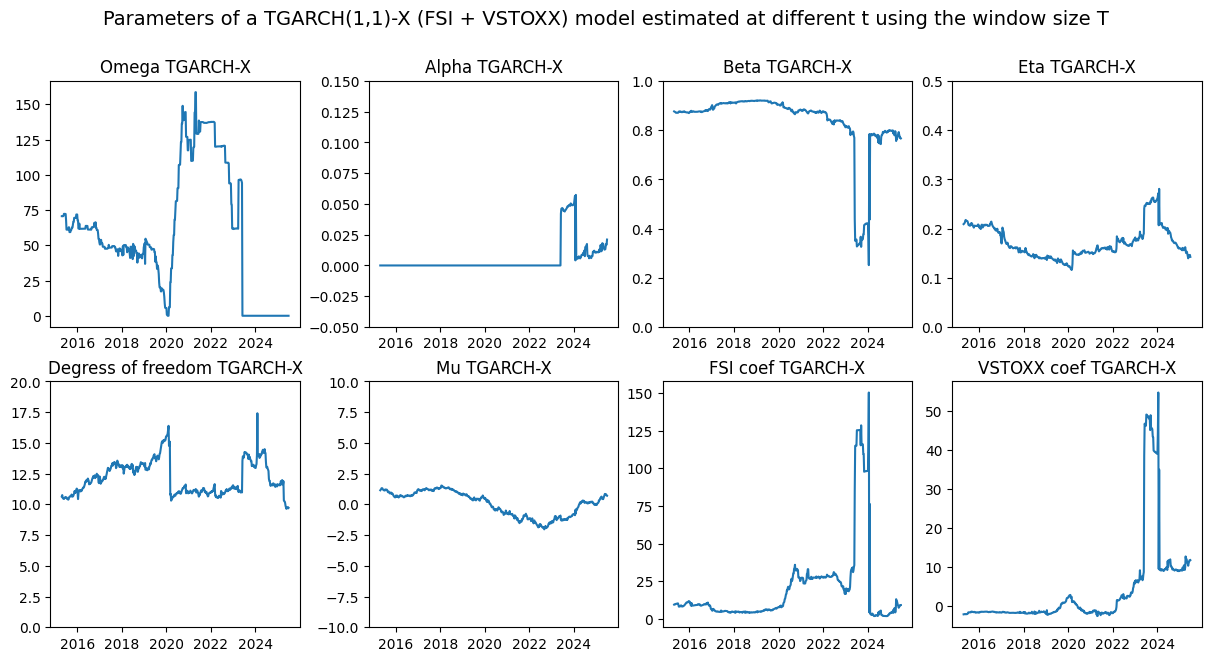

In [ ]:


fig, axs = plt.subplots(2, 4, figsize=(12, 6.5), constrained_layout=True)
fig.suptitle('Parameters of a TGARCH(1,1)-X (FSI + VSTOXX) model estimated at different t using the window size T\n', fontsize=14)
axs[0,0].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,0]);      axs[0, 0].set_title('Omega TGARCH-X')
axs[0,1].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,1]);      axs[0, 1].set_title('Alpha TGARCH-X'); axs[0, 1].set_ylim(-0.05, 0.15)
axs[0,2].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,2]);      axs[0, 2].set_title('Beta TGARCH-X'); axs[0, 2].set_ylim(0.0, 1)
axs[0,3].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,3]);      axs[0, 3].set_title('Eta TGARCH-X'); axs[0, 3].set_ylim(0, 0.5)
axs[1,0].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,4]);      axs[1, 0].set_title('Degress of freedom TGARCH-X'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,5]);      axs[1, 1].set_title('Mu TGARCH-X'); axs[1, 1].set_ylim(-10, 10)
axs[1,2].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,6]);      axs[1, 2].set_title('FSI coef TGARCH-X')
axs[1,3].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,7]);      axs[1, 3].set_title('VSTOXX coef TGARCH-X')


plt.show()

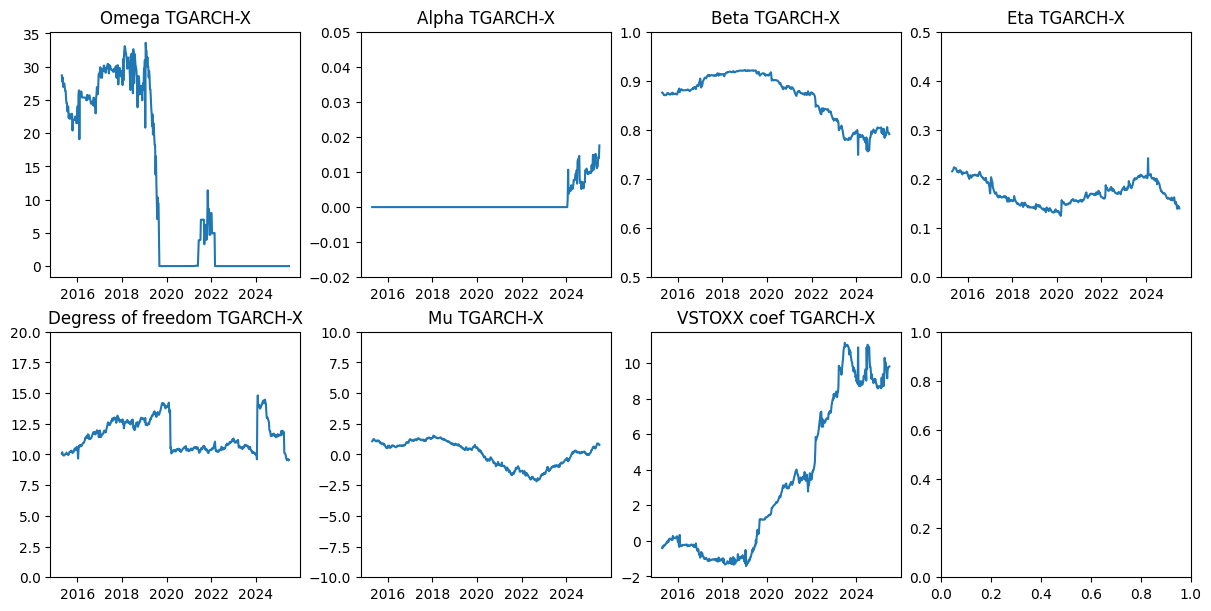

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_TGARCHX[:,0]);      axs[0, 0].set_title('Omega TGARCH-X')
axs[0,1].plot(combined[T:H].index, parameters_TGARCHX[:,1]);      axs[0, 1].set_title('Alpha TGARCH-X'); axs[0, 1].set_ylim(-0.02, 0.05)
axs[0,2].plot(combined[T:H].index, parameters_TGARCHX[:,2]);      axs[0, 2].set_title('Beta TGARCH-X'); axs[0, 2].set_ylim(0.5, 1)
axs[0,3].plot(combined[T:H].index, parameters_TGARCHX[:,3]);      axs[0, 3].set_title('Eta TGARCH-X'); axs[0, 3].set_ylim(0, 0.5)
axs[1,0].plot(combined[T:H].index, parameters_TGARCHX[:,4]);      axs[1, 0].set_title('Degress of freedom TGARCH-X'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_TGARCHX[:,5]);      axs[1, 1].set_title('Mu TGARCH-X'); axs[1, 1].set_ylim(-10, 10)
axs[1,2].plot(combined[T:H].index, parameters_TGARCHX[:,6]);      axs[1, 2].set_title('VSTOXX coef TGARCH-X')

plt.show()

# **TGARCH Estimation (skip)**

In [ ]:
y = combined['Log Return'].to_numpy()


def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu):
  omega, alpha, beta, eta = theta
  e_t_lagged = y_t_lagged - mu
  return omega + (alpha + eta * np.where(e_t_lagged < 0, 1, 0)) * (e_t_lagged) ** 2 + beta * variance_t_lagged

def total_neg_loglik(parameters, y, variance_0):
  omega, alpha, beta, eta, d, mu = parameters[:6]
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0  or eta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln takes to much time

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta, eta), mu)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll



def tgarch(y, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8, 0.1]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0]))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (0.0, 0.999) ,(2.01, 200.0), (None, None)]
  lc = LinearConstraint(np.r_[0, 1, 1, 0.5, 0, 0], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, eta_hat, d_hat, mu_hat = res.x # * means rest coefs are gamma

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, eta={eta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat, eta_hat), mu_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_TGARCH = np.empty(len(y))
parameters_TGARCH = np.empty((int(H-T),int(6)))

vol_TGARCH[:T+1], parameters_TGARCH[0] = tgarch(y[:T], variance_0)
for t in range(T+1,H):  #so far runs 17 mins for weekly
  print(t)
  vol, parameters_TGARCH[t-T] = tgarch(y[t-T:t], vol_TGARCH[t-T-1] ** 2, parameters_TGARCH[t-T-1])
  vol_TGARCH[t] = vol[-1]

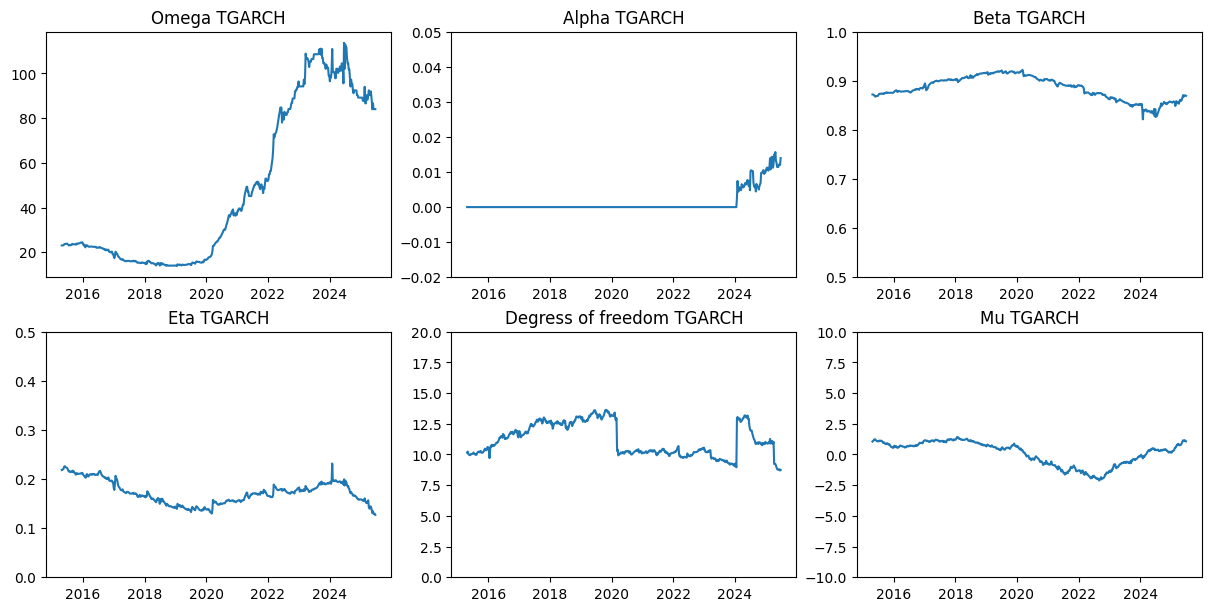

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_TGARCH[:,0]);      axs[0, 0].set_title('Omega TGARCH')
axs[0,1].plot(combined[T:H].index, parameters_TGARCH[:,1]);      axs[0, 1].set_title('Alpha TGARCH'); axs[0, 1].set_ylim(-0.02, 0.05)
axs[0,2].plot(combined[T:H].index, parameters_TGARCH[:,2]);      axs[0, 2].set_title('Beta TGARCH'); axs[0, 2].set_ylim(0.5, 1)
axs[1,0].plot(combined[T:H].index, parameters_TGARCH[:,3]);      axs[1,0].set_title('Eta TGARCH'); axs[1, 0].set_ylim(0, 0.5)
axs[1,1].plot(combined[T:H].index, parameters_TGARCH[:,4]);      axs[1, 1].set_title('Degress of freedom TGARCH'); axs[1, 1].set_ylim(0, 20)
axs[1,2].plot(combined[T:H].index, parameters_TGARCH[:,5]);      axs[1, 2].set_title('Mu TGARCH'); axs[1, 2].set_ylim(-10, 10)
plt.show()

**To save files (comments are toggled depending on which variables were included)**

In [ ]:
# pd.DataFrame(vol_GARCHX).to_csv('vol_GARCHX_FSI.csv', index=False)
# pd.DataFrame(vol_GARCH).to_csv('vol_GARCH.csv', index=False)
pd.DataFrame(vol_TGARCHX).to_csv('vol_TGARCHX_FSI.csv', index=False)
#pd.DataFrame(vol_TGARCH).to_csv('vol_TGARCH.csv', index=False)

In [ ]:
#pd.DataFrame(parameters_GARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu', 'FSI']).to_csv('parameters_GARCHX_FSI.csv')
#pd.DataFrame(parameters_GARCH, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu']).to_csv('parameters_GARCH.csv')
pd.DataFrame(parameters_TGARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu', 'FSI']).to_csv('parameters_TGARCHX_FSI.csv')
#pd.DataFrame(parameters_TGARCH, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu']).to_csv('parameters_TGARCH.csv')

In [ ]:
pd.DataFrame(vol_GARCHX).to_csv('vol_GARCHX_VSTOXX.csv', index=False)
pd.DataFrame(vol_TGARCHX).to_csv('vol_TGARCHX_VSTOXX.csv', index=False)

In [ ]:
pd.DataFrame(vol_GARCHX).to_csv('vol_GARCHX_FSI_VSTOXX.csv', index=False)
# pd.DataFrame(vol_TGARCHX).to_csv('vol_TGARCHX_FSI_VSTOXX.csv', index=False)

In [ ]:
pd.DataFrame(parameters_GARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu', 'VSTOXX']).to_csv('parameters_GARCHX_VSTOXX.csv')
pd.DataFrame(parameters_TGARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu', 'VSTOXX']).to_csv('parameters_TGARCHX_VSTOXX.csv')

In [ ]:
#pd.DataFrame(parameters_GARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu', 'FSI', 'VSTOXX']).to_csv('parameters_GARCHX_FSI_VSTOXX.csv')
pd.DataFrame(parameters_TGARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu', 'FSI' ,'VSTOXX']).to_csv('parameters_TGARCHX_FSI_VSTOXX.csv')

# **Risk mearures estimation Weekly log-losses**

In [ ]:
vol_GARCH = pd.read_csv('MasterThesis/data/vol/vol_GARCH.csv')['0']
vol_GARCHX_FSI = pd.read_csv('MasterThesis/data/vol/vol_GARCHX_FSI.csv')['0']
vol_GARCHX_VSTOXX = pd.read_csv('MasterThesis/data/vol/vol_GARCHX_VSTOXX.csv')['0']
vol_GARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/vol_GARCHX_FSI_VSTOXX.csv')['0']

vol_TGARCH = pd.read_csv('MasterThesis/data/vol/vol_TGARCH.csv')['0']
vol_TGARCHX_FSI = pd.read_csv('MasterThesis/data/vol/vol_TGARCHX_FSI.csv')['0']
vol_TGARCHX_VSTOXX = pd.read_csv('MasterThesis/data/vol/vol_TGARCHX_VSTOXX.csv')['0']
vol_TGARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/vol_TGARCHX_FSI_VSTOXX.csv')['0']

def unpack_log_vol(vol__log_name):
  df =  pd.read_csv(vol__log_name)
  vol_log = df['sigma_hat']
  vol_log = pd.concat([pd.Series(vol_log[0:5].mean()), vol_log], ignore_index=True) #imputes first value (was not returned by R package),
  # but does not matter much, just for index consistency
  parameters = df[df.columns[2:]][T-2:-1].reset_index(drop = True)
  parameters.rename(columns={'mu': 'Mu'}, inplace = True)
  return vol_log, parameters


vol_Log_GARCH, parameters_Log_GARCH = unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCH.csv')
vol_Log_GARCHX_FSI, parameters_Log_GARCHX_FSI = unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCHX_FSI.csv')
vol_Log_GARCHX_VSTOXX, parameters_Log_GARCHX_VSTOXX = unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCHX_VSTOXX.csv')
vol_Log_GARCHX_FSI_VSTOXX, parameters_Log_GARCHX_FSI_VSTOXX = unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCHX_FSI_VSTOXX.csv')
vol_Log_GARCHX_FSI_Euribor, parameters_Log_GARCHX_FSI_Euribor=unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCHX_FSI_Euribor.csv')
vol_Log_GARCHX_FSI_VSTOXX_Euribor, parameters_Log_GARCHX_FSI_VSTOXX_Euribor= unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCHX_FSI_VSTOXX_Euribor.csv')
vol_Log_GARCHX_VSTOXX_Euribor, parameters_Log_GARCHX_VSTOXX_Euribor= unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCHX_VSTOXX_Euribor.csv')
vol_Log_GARCHX_Euribor, parameters_Log_GARCHX_Euribor = unpack_log_vol('MasterThesis/data/vol/vol_Log_GARCHX_Euribor.csv')

vol_Log_TGARCH, parameters_Log_TGARCH = unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCH.csv')
vol_Log_TGARCHX_FSI, parameters_Log_TGARCHX_FSI = unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCHX_FSI.csv')
vol_Log_TGARCHX_VSTOXX, parameters_Log_TGARCHX_VSTOXX = unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCHX_VSTOXX.csv')
vol_Log_TGARCHX_FSI_VSTOXX, parameters_Log_TGARCHX_FSI_VSTOXX = unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCHX_FSI_VSTOXX.csv')
vol_Log_TGARCHX_FSI_Euribor, parameters_Log_TGARCHX_FSI_Euribor=unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCHX_FSI_Euribor.csv')
vol_Log_TGARCHX_FSI_VSTOXX_Euribor, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor=unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCHX_FSI_VSTOXX_Euribor.csv')
vol_Log_TGARCHX_VSTOXX_Euribor, parameters_Log_TGARCHX_VSTOXX_Euribor = unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCHX_VSTOXX_Euribor.csv')
vol_Log_TGARCHX_Euribor, parameters_Log_TGARCHX_Euribor = unpack_log_vol('MasterThesis/data/vol/vol_Log_TGARCHX_Euribor.csv')

parameters_GARCH = pd.read_csv('MasterThesis/data/vol/parameters_GARCH.csv')
parameters_GARCHX_FSI = pd.read_csv('MasterThesis/data/vol/parameters_GARCHX_FSI.csv')
parameters_GARCHX_VSTOXX = pd.read_csv('MasterThesis/data/vol/parameters_GARCHX_VSTOXX.csv')
parameters_GARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/parameters_GARCHX_FSI_VSTOXX.csv')

parameters_TGARCH = pd.read_csv('MasterThesis/data/vol/parameters_TGARCH.csv')
parameters_TGARCHX_FSI = pd.read_csv('MasterThesis/data/vol/parameters_TGARCHX_FSI.csv')
parameters_TGARCHX_VSTOXX = pd.read_csv('MasterThesis/data/vol/parameters_TGARCHX_VSTOXX.csv')
parameters_TGARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/parameters_TGARCHX_FSI_VSTOXX.csv')

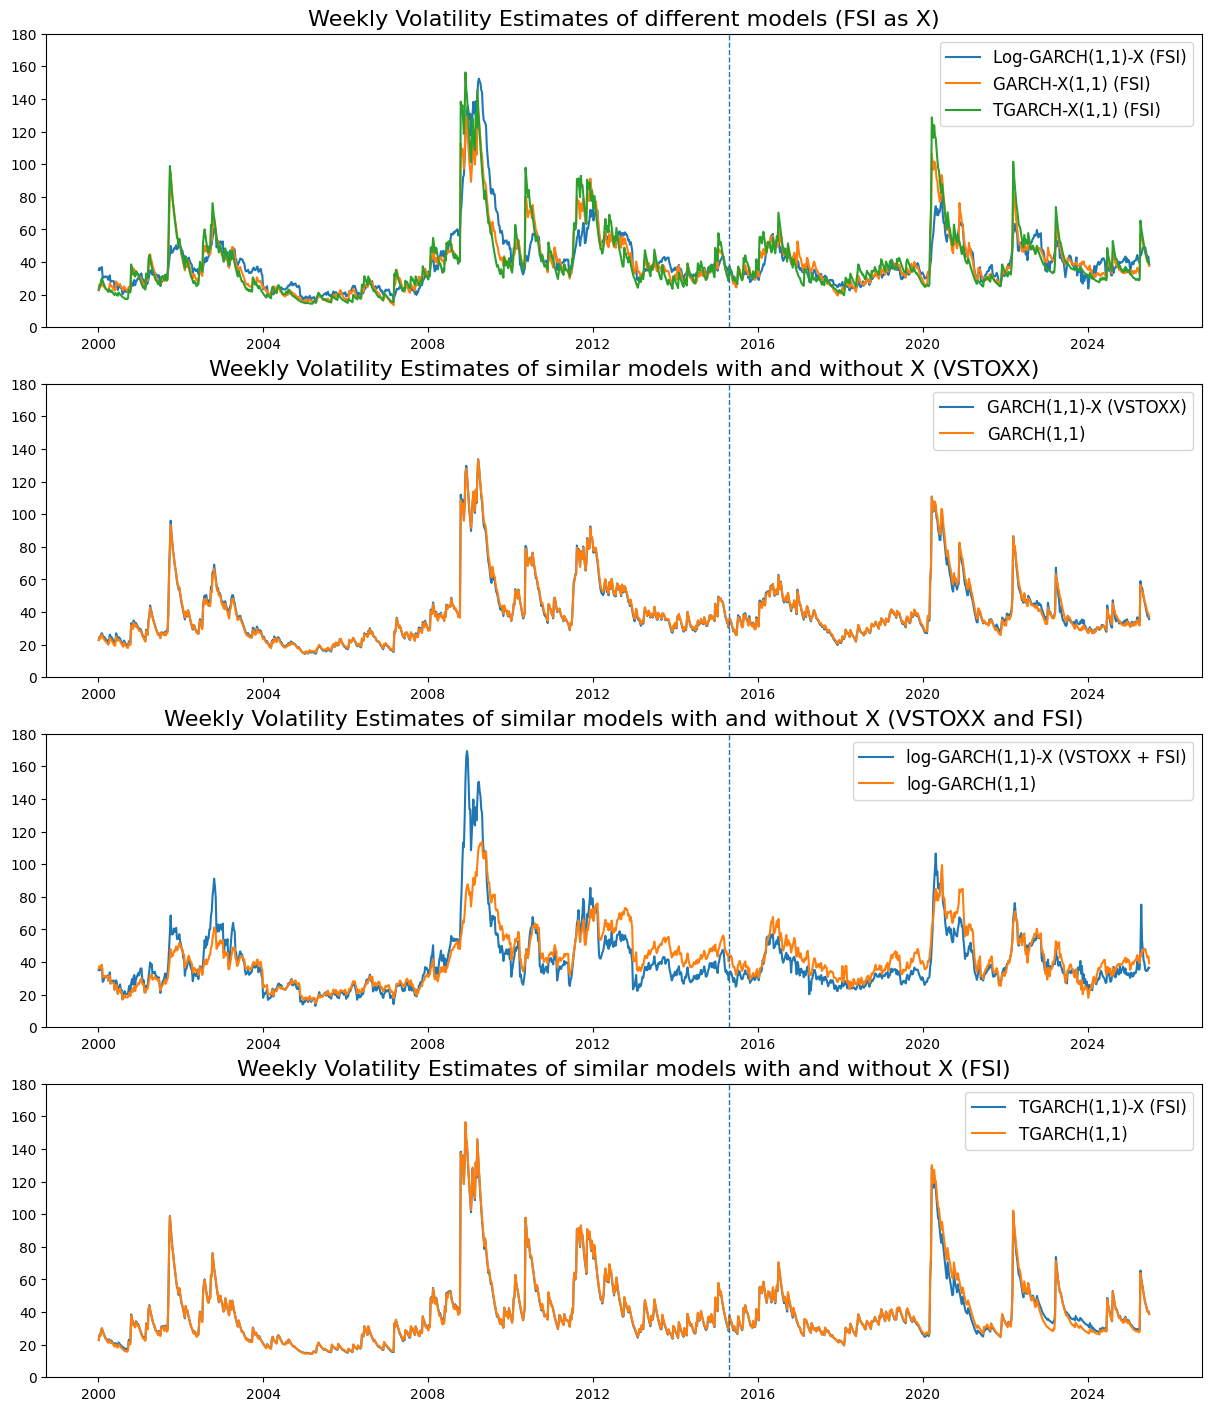

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index, vol_Log_GARCHX_FSI, label='Log-GARCH(1,1)-X (FSI)')
axs[0].plot(combined.index, vol_GARCHX_FSI, label='GARCH-X(1,1) (FSI)')
axs[0].plot(combined.index, vol_TGARCHX_FSI, label='TGARCH-X(1,1) (FSI)')

axs[0].legend(loc="upper right", fontsize=12)
axs[0].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[0].set_title('Weekly Volatility Estimates of different models (FSI as X)', fontsize=16)
axs[0].set_ylim(0, 180)


axs[1].plot(combined.index, vol_GARCHX_VSTOXX, label='GARCH(1,1)-X (VSTOXX)')
axs[1].plot(combined.index, vol_GARCH, label='GARCH(1,1)')
axs[1].legend(loc="upper right", fontsize=12)
axs[1].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[1].set_title('Weekly Volatility Estimates of similar models with and without X (VSTOXX)', fontsize=16)
axs[1].set_ylim(0, 180)

axs[2].plot(combined.index, vol_Log_GARCHX_FSI_VSTOXX, label='log-GARCH(1,1)-X (VSTOXX + FSI)')
axs[2].plot(combined.index, vol_Log_GARCH, label='log-GARCH(1,1)')
axs[2].legend(loc="upper right", fontsize=12)
axs[2].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[2].set_title('Weekly Volatility Estimates of similar models with and without X (VSTOXX and FSI)', fontsize=16)
axs[2].set_ylim(0, 180)

axs[3].plot(combined.index, vol_TGARCHX_FSI, label='TGARCH(1,1)-X (FSI)')
axs[3].plot(combined.index, vol_TGARCH, label='TGARCH(1,1)')
axs[3].legend(loc="upper right", fontsize=12)
axs[3].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[3].set_title('Weekly Volatility Estimates of similar models with and without X (FSI)', fontsize=16)
axs[3].set_ylim(0, 180)

plt.show()

In [ ]:

std_loss_GARCH = np.zeros(H)
std_loss_GARCHX_FSI = np.zeros(H)
std_loss_GARCHX_VSTOXX = np.zeros(H)
std_loss_GARCHX_FSI_VSTOXX = np.zeros(H)

std_loss_TGARCH = np.zeros(H)
std_loss_TGARCHX_FSI = np.zeros(H)
std_loss_TGARCHX_VSTOXX = np.zeros(H)
std_loss_TGARCHX_FSI_VSTOXX = np.zeros(H)

std_loss_Log_GARCH = np.zeros(H)
std_loss_Log_GARCHX_FSI = np.zeros(H)
std_loss_Log_GARCHX_VSTOXX = np.zeros(H)
std_loss_Log_GARCHX_FSI_VSTOXX = np.zeros(H)
std_loss_Log_GARCHX_FSI_Euribor = np.zeros(H)
std_loss_Log_GARCHX_FSI_VSTOXX_Euribor = np.zeros(H)
std_loss_Log_GARCHX_VSTOXX_Euribor = np.zeros(H)
std_loss_Log_GARCHX_Euribor = np.zeros(H)

std_loss_Log_TGARCH = np.zeros(H)
std_loss_Log_TGARCHX_FSI = np.zeros(H)
std_loss_Log_TGARCHX_VSTOXX = np.zeros(H)
std_loss_Log_TGARCHX_FSI_VSTOXX = np.zeros(H)
std_loss_Log_TGARCHX_FSI_Euribor = np.zeros(H)
std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor = np.zeros(H)
std_loss_Log_TGARCHX_VSTOXX_Euribor = np.zeros(H)
std_loss_Log_TGARCHX_Euribor = np.zeros(H)

def st_loss(y, par, vol, start_index, end_index):
  return - (y[start_index:end_index] - par['Mu'][start_index]) / vol[start_index:end_index].to_numpy() # par is already shifted


std_loss_GARCH[0:T] = st_loss(combined['Log Return'], parameters_GARCH, vol_GARCH, 0, T)
std_loss_GARCHX_FSI[0:T] = st_loss(combined['Log Return'], parameters_GARCHX_FSI, vol_GARCHX_FSI, 0, T)
std_loss_GARCHX_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_GARCHX_VSTOXX, vol_GARCHX_VSTOXX, 0, T)
std_loss_GARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_GARCHX_FSI_VSTOXX, vol_GARCHX_FSI_VSTOXX, 0, T)

std_loss_TGARCH[0:T] = st_loss(combined['Log Return'], parameters_TGARCH, vol_TGARCH, 0, T)
std_loss_TGARCHX_FSI[0:T] = st_loss(combined['Log Return'], parameters_TGARCHX_FSI, vol_TGARCHX_FSI, 0, T)
std_loss_TGARCHX_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_TGARCHX_VSTOXX, vol_TGARCHX_VSTOXX, 0, T)
std_loss_TGARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_TGARCHX_FSI_VSTOXX, vol_TGARCHX_FSI_VSTOXX, 0, T)

std_loss_Log_GARCH[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCH, vol_Log_GARCH, 0, T)
std_loss_Log_GARCHX_FSI[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_FSI, vol_Log_GARCHX_FSI, 0, T)
std_loss_Log_GARCHX_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_VSTOXX, vol_Log_GARCHX_VSTOXX, 0, T)
std_loss_Log_GARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX, vol_Log_GARCHX_FSI_VSTOXX, 0, T)
std_loss_Log_GARCHX_FSI_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_FSI_Euribor, vol_Log_GARCHX_FSI_Euribor, 0, T)
std_loss_Log_GARCHX_FSI_VSTOXX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX_Euribor, vol_Log_GARCHX_FSI_VSTOXX_Euribor, 0, T)
std_loss_Log_GARCHX_VSTOXX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_VSTOXX_Euribor, vol_Log_GARCHX_VSTOXX_Euribor, 0, T)
std_loss_Log_GARCHX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_Euribor, vol_Log_GARCHX_Euribor, 0, T)

std_loss_Log_TGARCH[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCH, vol_Log_TGARCH, 0, T)
std_loss_Log_TGARCHX_FSI[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_FSI, vol_Log_TGARCHX_FSI, 0, T)
std_loss_Log_TGARCHX_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_VSTOXX, vol_Log_TGARCHX_VSTOXX, 0, T)
std_loss_Log_TGARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX, vol_Log_TGARCHX_FSI_VSTOXX, 0, T)
std_loss_Log_TGARCHX_FSI_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_FSI_Euribor, vol_Log_TGARCHX_FSI_Euribor, 0, T)
std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX_Euribor, vol_Log_TGARCHX_FSI_VSTOXX_Euribor, 0, T)
std_loss_Log_TGARCHX_VSTOXX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_VSTOXX_Euribor, vol_Log_TGARCHX_VSTOXX_Euribor, 0, T)
std_loss_Log_TGARCHX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_Euribor, vol_Log_TGARCHX_Euribor, 0, T)


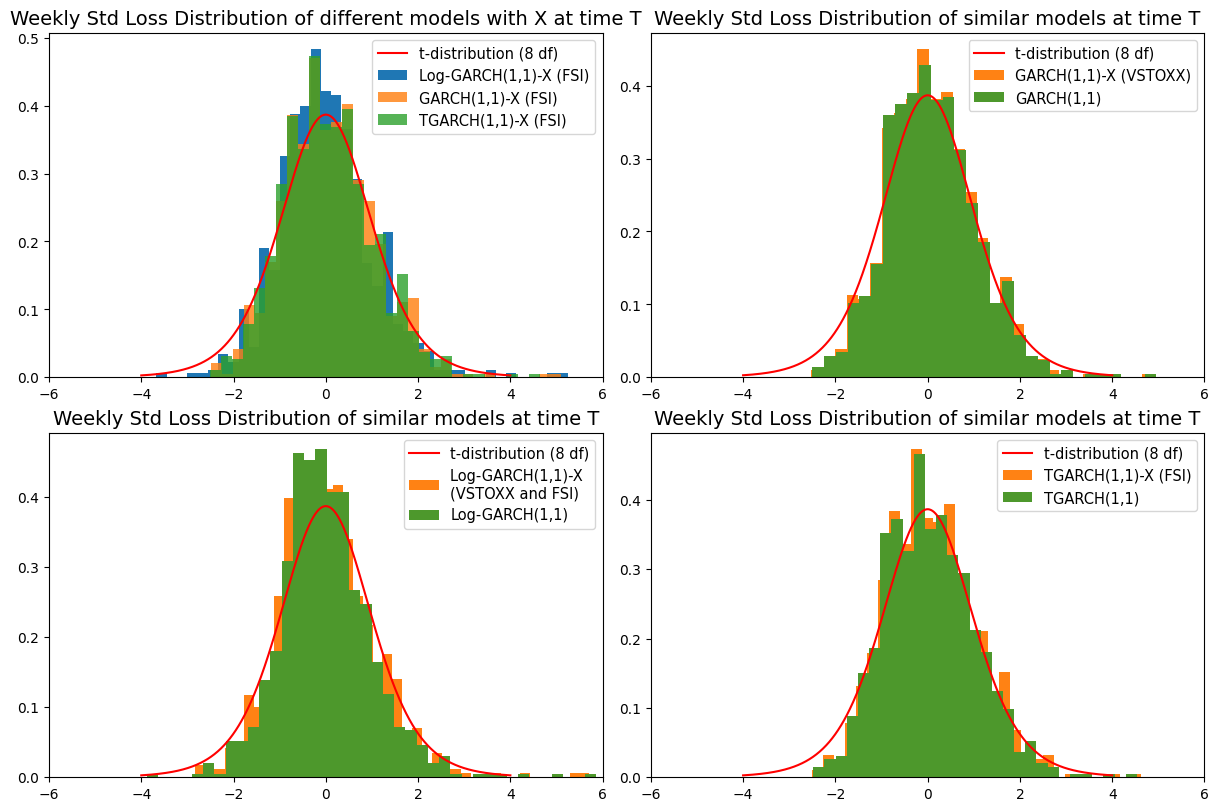

In [ ]:

x_ax_std = np.linspace(-4, 4, 1000)

fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

axs[0,0].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[0,0].hist(std_loss_Log_GARCHX_FSI[0:T], bins=40, density=True)
axs[0,0].hist(std_loss_GARCHX_FSI[0:T], bins=40, alpha=0.8,density=True)
axs[0,0].hist(std_loss_TGARCHX_FSI[0:T], bins=40, alpha=0.8,density=True)
axs[0,0].legend(['t-distribution (8 df)', 'Log-GARCH(1,1)-X (FSI)', 'GARCH(1,1)-X (FSI)', 'TGARCH(1,1)-X (FSI)'], loc='upper right', fontsize=10.5)
axs[0,0].set_xlim(-6, 6)
axs[0,0].set_title('Weekly Std Loss Distribution of different models with X at time T', fontsize=14)

axs[0,1].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[0,1].hist(std_loss_GARCHX_VSTOXX[0:T], bins=40, density=True, color='#ff8214')
axs[0,1].hist(std_loss_GARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[0,1].legend(['t-distribution (8 df)', 'GARCH(1,1)-X (VSTOXX)', 'GARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[0,1].set_xlim(-6, 6)
axs[0,1].set_title('Weekly Std Loss Distribution of similar models at time T', fontsize=14)

axs[1,0].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[1,0].hist(std_loss_Log_GARCHX_FSI_VSTOXX[0:T], bins=40, density=True, color='#ff8214')
axs[1,0].hist(std_loss_Log_GARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[1,0].legend(['t-distribution (8 df)', 'Log-GARCH(1,1)-X \n(VSTOXX and FSI)', 'Log-GARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[1,0].set_xlim(-6, 6)
axs[1,0].set_title('Weekly Std Loss Distribution of similar models at time T', fontsize=14)


axs[1,1].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[1,1].hist(std_loss_TGARCHX_FSI[0:T], bins=40, density=True, color='#ff8214')
axs[1,1].hist(std_loss_TGARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[1,1].legend(['t-distribution (8 df)', 'TGARCH(1,1)-X (FSI)', 'TGARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[1,1].set_xlim(-6, 6)
axs[1,1].set_title('Weekly Std Loss Distribution of similar models at time T', fontsize=14)





# #4d982c - green, #ff8214 - orange, #1f77b4 - blue


plt.show()

In [ ]:

VaR_GARCH = np.zeros(H-T)
VaR_GARCHX_FSI = np.zeros(H-T)
VaR_GARCHX_VSTOXX = np.zeros(H-T)
VaR_GARCHX_FSI_VSTOXX = np.zeros(H-T)

VaR_TGARCH = np.zeros(H-T)
VaR_TGARCHX_FSI = np.zeros(H-T)
VaR_TGARCHX_VSTOXX = np.zeros(H-T)
VaR_TGARCHX_FSI_VSTOXX = np.zeros(H-T)

VaR_Log_GARCH = np.zeros(H-T)
VaR_Log_GARCHX_FSI = np.zeros(H-T)
VaR_Log_GARCHX_VSTOXX = np.zeros(H-T)
VaR_Log_GARCHX_FSI_VSTOXX = np.zeros(H-T)
VaR_Log_GARCHX_FSI_Euribor = np.zeros(H-T)
VaR_Log_GARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)
VaR_Log_GARCHX_VSTOXX_Euribor = np.zeros(H-T)
VaR_Log_GARCHX_Euribor = np.zeros(H-T)

VaR_Log_TGARCH = np.zeros(H-T)
VaR_Log_TGARCHX_FSI = np.zeros(H-T)
VaR_Log_TGARCHX_VSTOXX = np.zeros(H-T)
VaR_Log_TGARCHX_FSI_VSTOXX = np.zeros(H-T)
VaR_Log_TGARCHX_FSI_Euribor = np.zeros(H-T)
VaR_Log_TGARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)
VaR_Log_TGARCHX_VSTOXX_Euribor = np.zeros(H-T)
VaR_Log_TGARCHX_Euribor = np.zeros(H-T)

VaR_naive = np.zeros(H-T)


ES_GARCH = np.zeros(H-T)
ES_GARCHX_FSI = np.zeros(H-T)
ES_GARCHX_VSTOXX = np.zeros(H-T)
ES_GARCHX_FSI_VSTOXX = np.zeros(H-T)

ES_TGARCH = np.zeros(H-T)
ES_TGARCHX_FSI = np.zeros(H-T)
ES_TGARCHX_VSTOXX = np.zeros(H-T)
ES_TGARCHX_FSI_VSTOXX = np.zeros(H-T)

ES_Log_GARCH = np.zeros(H-T)
ES_Log_GARCHX_FSI = np.zeros(H-T)
ES_Log_GARCHX_VSTOXX = np.zeros(H-T)
ES_Log_GARCHX_FSI_VSTOXX = np.zeros(H-T)
ES_Log_GARCHX_FSI_Euribor = np.zeros(H-T)
ES_Log_GARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)
ES_Log_GARCHX_VSTOXX_Euribor = np.zeros(H-T)
ES_Log_GARCHX_Euribor = np.zeros(H-T)

ES_Log_TGARCH = np.zeros(H-T)
ES_Log_TGARCHX_FSI = np.zeros(H-T)
ES_Log_TGARCHX_VSTOXX = np.zeros(H-T)
ES_Log_TGARCHX_FSI_VSTOXX = np.zeros(H-T)
ES_Log_TGARCHX_FSI_Euribor = np.zeros(H-T)
ES_Log_TGARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)
ES_Log_TGARCHX_VSTOXX_Euribor = np.zeros(H-T)
ES_Log_TGARCHX_Euribor = np.zeros(H-T)

ES_naive = np.zeros(H-T)


def risk_measures(y, par, vol, prev_std_losses, t, t_start):
  mu = par['Mu'][t_start] # t_start are for array already shifted
  new_std_loss = - (y.to_numpy()[t] - mu) / vol[t]
  std_loss = np.append(prev_std_losses, new_std_loss)
  VaR = np.quantile(std_loss[t_start:t], 0.95) * vol[t] - mu
  mask = (std_loss[t_start:t] * vol[t] - mu) > VaR
  ES = (np.mean(std_loss[t_start:t][mask]) * vol[t] - mu)
  return new_std_loss, VaR, ES

for t in range(T,H):

  std_loss_GARCH[t], VaR_GARCH[t-T], ES_GARCH[t-T] = risk_measures(combined['Log Return'], parameters_GARCH, vol_GARCH, std_loss_GARCH, t, t-T)
  std_loss_GARCHX_FSI[t], VaR_GARCHX_FSI[t-T], ES_GARCHX_FSI[t-T] = risk_measures(combined['Log Return'], parameters_GARCHX_FSI, vol_GARCHX_FSI, std_loss_GARCHX_FSI, t, t-T)
  std_loss_GARCHX_VSTOXX[t], VaR_GARCHX_VSTOXX[t-T], ES_GARCHX_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_GARCHX_VSTOXX, vol_GARCHX_VSTOXX, std_loss_GARCHX_VSTOXX, t, t-T)
  std_loss_GARCHX_FSI_VSTOXX[t], VaR_GARCHX_FSI_VSTOXX[t-T], ES_GARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_GARCHX_FSI_VSTOXX, vol_GARCHX_FSI_VSTOXX, std_loss_GARCHX_FSI_VSTOXX, t, t-T)

  std_loss_TGARCH[t], VaR_TGARCH[t-T], ES_TGARCH[t-T] = risk_measures(combined['Log Return'], parameters_TGARCH, vol_TGARCH, std_loss_TGARCH, t, t-T)
  std_loss_TGARCHX_FSI[t], VaR_TGARCHX_FSI[t-T], ES_TGARCHX_FSI[t-T] = risk_measures(combined['Log Return'], parameters_TGARCHX_FSI, vol_TGARCHX_FSI, std_loss_TGARCHX_FSI, t, t-T)
  std_loss_TGARCHX_VSTOXX[t], VaR_TGARCHX_VSTOXX[t-T], ES_TGARCHX_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_TGARCHX_VSTOXX, vol_TGARCHX_VSTOXX, std_loss_TGARCHX_VSTOXX, t, t-T)
  std_loss_TGARCHX_FSI_VSTOXX[t], VaR_TGARCHX_FSI_VSTOXX[t-T], ES_TGARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_TGARCHX_FSI_VSTOXX, vol_TGARCHX_FSI_VSTOXX, std_loss_TGARCHX_FSI_VSTOXX, t, t-T)

  std_loss_Log_GARCH[t], VaR_Log_GARCH[t-T], ES_Log_GARCH[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCH, vol_Log_GARCH, std_loss_Log_GARCH, t, t-T)
  std_loss_Log_GARCHX_FSI[t], VaR_Log_GARCHX_FSI[t-T], ES_Log_GARCHX_FSI[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_FSI, vol_Log_GARCHX_FSI, std_loss_Log_GARCHX_FSI, t, t-T)
  std_loss_Log_GARCHX_VSTOXX[t], VaR_Log_GARCHX_VSTOXX[t-T], ES_Log_GARCHX_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_VSTOXX, vol_Log_GARCHX_VSTOXX, std_loss_Log_GARCHX_VSTOXX, t, t-T)
  std_loss_Log_GARCHX_FSI_VSTOXX[t], VaR_Log_GARCHX_FSI_VSTOXX[t-T], ES_Log_GARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX, vol_Log_GARCHX_FSI_VSTOXX, std_loss_Log_GARCHX_FSI_VSTOXX, t, t-T)
  std_loss_Log_GARCHX_FSI_Euribor[t], VaR_Log_GARCHX_FSI_Euribor[t-T], ES_Log_GARCHX_FSI_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_FSI_Euribor, vol_Log_GARCHX_FSI_Euribor, std_loss_Log_GARCHX_FSI_Euribor, t, t-T)
  std_loss_Log_GARCHX_FSI_VSTOXX_Euribor[t], VaR_Log_GARCHX_FSI_VSTOXX_Euribor[t-T], ES_Log_GARCHX_FSI_VSTOXX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX_Euribor, vol_Log_GARCHX_FSI_VSTOXX_Euribor, std_loss_Log_GARCHX_FSI_VSTOXX_Euribor, t, t-T)
  std_loss_Log_GARCHX_VSTOXX_Euribor[t], VaR_Log_GARCHX_VSTOXX_Euribor[t-T], ES_Log_GARCHX_VSTOXX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_VSTOXX_Euribor, vol_Log_GARCHX_VSTOXX_Euribor, std_loss_Log_GARCHX_VSTOXX_Euribor, t, t-T)
  std_loss_Log_GARCHX_Euribor[t], VaR_Log_GARCHX_Euribor[t-T], ES_Log_GARCHX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_Euribor, vol_Log_GARCHX_Euribor, std_loss_Log_GARCHX_Euribor, t, t-T)

  std_loss_Log_TGARCH[t], VaR_Log_TGARCH[t-T], ES_Log_TGARCH[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCH, vol_Log_TGARCH, std_loss_Log_TGARCH, t, t-T)
  std_loss_Log_TGARCHX_FSI[t], VaR_Log_TGARCHX_FSI[t-T], ES_Log_TGARCHX_FSI[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_FSI, vol_Log_TGARCHX_FSI, std_loss_Log_TGARCHX_FSI, t, t-T)
  std_loss_Log_TGARCHX_VSTOXX[t], VaR_Log_TGARCHX_VSTOXX[t-T], ES_Log_TGARCHX_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_VSTOXX, vol_Log_TGARCHX_VSTOXX, std_loss_Log_TGARCHX_VSTOXX, t, t-T)
  std_loss_Log_TGARCHX_FSI_VSTOXX[t], VaR_Log_TGARCHX_FSI_VSTOXX[t-T], ES_Log_TGARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX, vol_Log_TGARCHX_FSI_VSTOXX, std_loss_Log_TGARCHX_FSI_VSTOXX, t, t-T)
  std_loss_Log_TGARCHX_FSI_Euribor[t], VaR_Log_TGARCHX_FSI_Euribor[t-T], ES_Log_TGARCHX_FSI_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_FSI_Euribor, vol_Log_TGARCHX_FSI_Euribor, std_loss_Log_TGARCHX_FSI_Euribor, t, t-T)
  std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor[t], VaR_Log_TGARCHX_FSI_VSTOXX_Euribor[t-T], ES_Log_TGARCHX_FSI_VSTOXX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX_Euribor, vol_Log_TGARCHX_FSI_VSTOXX_Euribor, std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor, t, t-T)
  std_loss_Log_TGARCHX_VSTOXX_Euribor[t], VaR_Log_TGARCHX_VSTOXX_Euribor[t-T], ES_Log_TGARCHX_VSTOXX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_VSTOXX_Euribor, vol_Log_TGARCHX_VSTOXX_Euribor, std_loss_Log_TGARCHX_VSTOXX_Euribor, t, t-T)
  std_loss_Log_TGARCHX_Euribor[t], VaR_Log_TGARCHX_Euribor[t-T], ES_Log_TGARCHX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_Euribor, vol_Log_TGARCHX_Euribor, std_loss_Log_TGARCHX_Euribor, t, t-T)


  Naive_losses = -combined['Log Return'][t-T:t]
  VaR_naive[t-T] = np.quantile(Naive_losses, 0.95)
  ES_naive[t-T] = Naive_losses[Naive_losses > VaR_naive[t-T]].mean()

VaR_ES = {
    'GARCH(1,1)' : [VaR_GARCH, ES_GARCH],
    'GARCH(1,1)-X (FSI)' : [VaR_GARCHX_FSI, ES_GARCHX_FSI],
    'GARCH(1,1)-X (VSTOXX)' : [VaR_GARCHX_VSTOXX, ES_GARCHX_VSTOXX],
    'GARCH(1,1)-X (FSI & VSTOXX)' : [VaR_GARCHX_FSI_VSTOXX, ES_GARCHX_FSI_VSTOXX],
    'TGARCH(1,1)' : [VaR_TGARCH, ES_TGARCH],
    'TGARCH(1,1)-X (FSI)' : [VaR_TGARCHX_FSI, ES_TGARCHX_FSI],
    'TGARCH(1,1)-X (VSTOXX)' : [VaR_TGARCHX_VSTOXX, ES_TGARCHX_VSTOXX],
    'TGARCH(1,1)-X (FSI & VSTOXX)' : [VaR_TGARCHX_FSI_VSTOXX, ES_TGARCHX_FSI_VSTOXX],
    'Log-GARCH(1,1)' : [VaR_Log_GARCH, ES_Log_GARCH],
    'Log-GARCH(1,1)-X (FSI)' : [VaR_Log_GARCHX_FSI, ES_Log_GARCHX_FSI],
    'Log-GARCH(1,1)-X (VSTOXX)' : [VaR_Log_GARCHX_VSTOXX, ES_Log_GARCHX_VSTOXX],
    'Log-GARCH(1,1)-X (FSI & VSTOXX)' : [VaR_Log_GARCHX_FSI_VSTOXX, ES_Log_GARCHX_FSI_VSTOXX],
    'Log-GARCH(1,1)-X (FSI & Euribor6m)' : [VaR_Log_GARCHX_FSI_Euribor, ES_Log_GARCHX_FSI_Euribor],
    'Log-GARCH(1,1)-X (FSI, VSTOXX, Euribor6m)' : [VaR_Log_GARCHX_FSI_VSTOXX_Euribor, ES_Log_GARCHX_FSI_VSTOXX_Euribor],
    'Log-GARCH(1,1)-X (VSTOXX & Euribor6m)' : [VaR_Log_GARCHX_VSTOXX_Euribor, ES_Log_GARCHX_VSTOXX_Euribor],
    'Log-GARCH(1,1)-X (Euribor6m)' : [VaR_Log_GARCHX_Euribor, ES_Log_GARCHX_Euribor],
    'Log-TGARCH(1,1)' : [VaR_Log_TGARCH, ES_Log_TGARCH],
    'Log-TGARCH(1,1)-X (FSI)' : [VaR_Log_TGARCHX_FSI, ES_Log_TGARCHX_FSI],
    'Log-TGARCH(1,1)-X (VSTOXX)' : [VaR_Log_TGARCHX_VSTOXX, ES_Log_TGARCHX_VSTOXX],
    'Log-TGARCH(1,1)-X (FSI & VSTOXX)' : [VaR_Log_TGARCHX_FSI_VSTOXX, ES_Log_TGARCHX_FSI_VSTOXX],
    'Log-TGARCH(1,1)-X (FSI & Euribor6m)' : [VaR_Log_TGARCHX_FSI_Euribor, ES_Log_TGARCHX_FSI_Euribor],
    'Log-TGARCH(1,1)-X (FSI, VSTOXX, Euribor6m)' : [VaR_Log_TGARCHX_FSI_VSTOXX_Euribor, ES_Log_TGARCHX_FSI_VSTOXX_Euribor],
    'Log-TGARCH(1,1)-X (VSTOXX & Euribor6m)' : [VaR_Log_TGARCHX_VSTOXX_Euribor, ES_Log_TGARCHX_VSTOXX_Euribor],
    'Log-TGARCH(1,1)-X (Euribor6m)' : [VaR_Log_TGARCHX_Euribor, ES_Log_TGARCHX_Euribor],
    'Naive' : [VaR_naive , ES_naive]
}



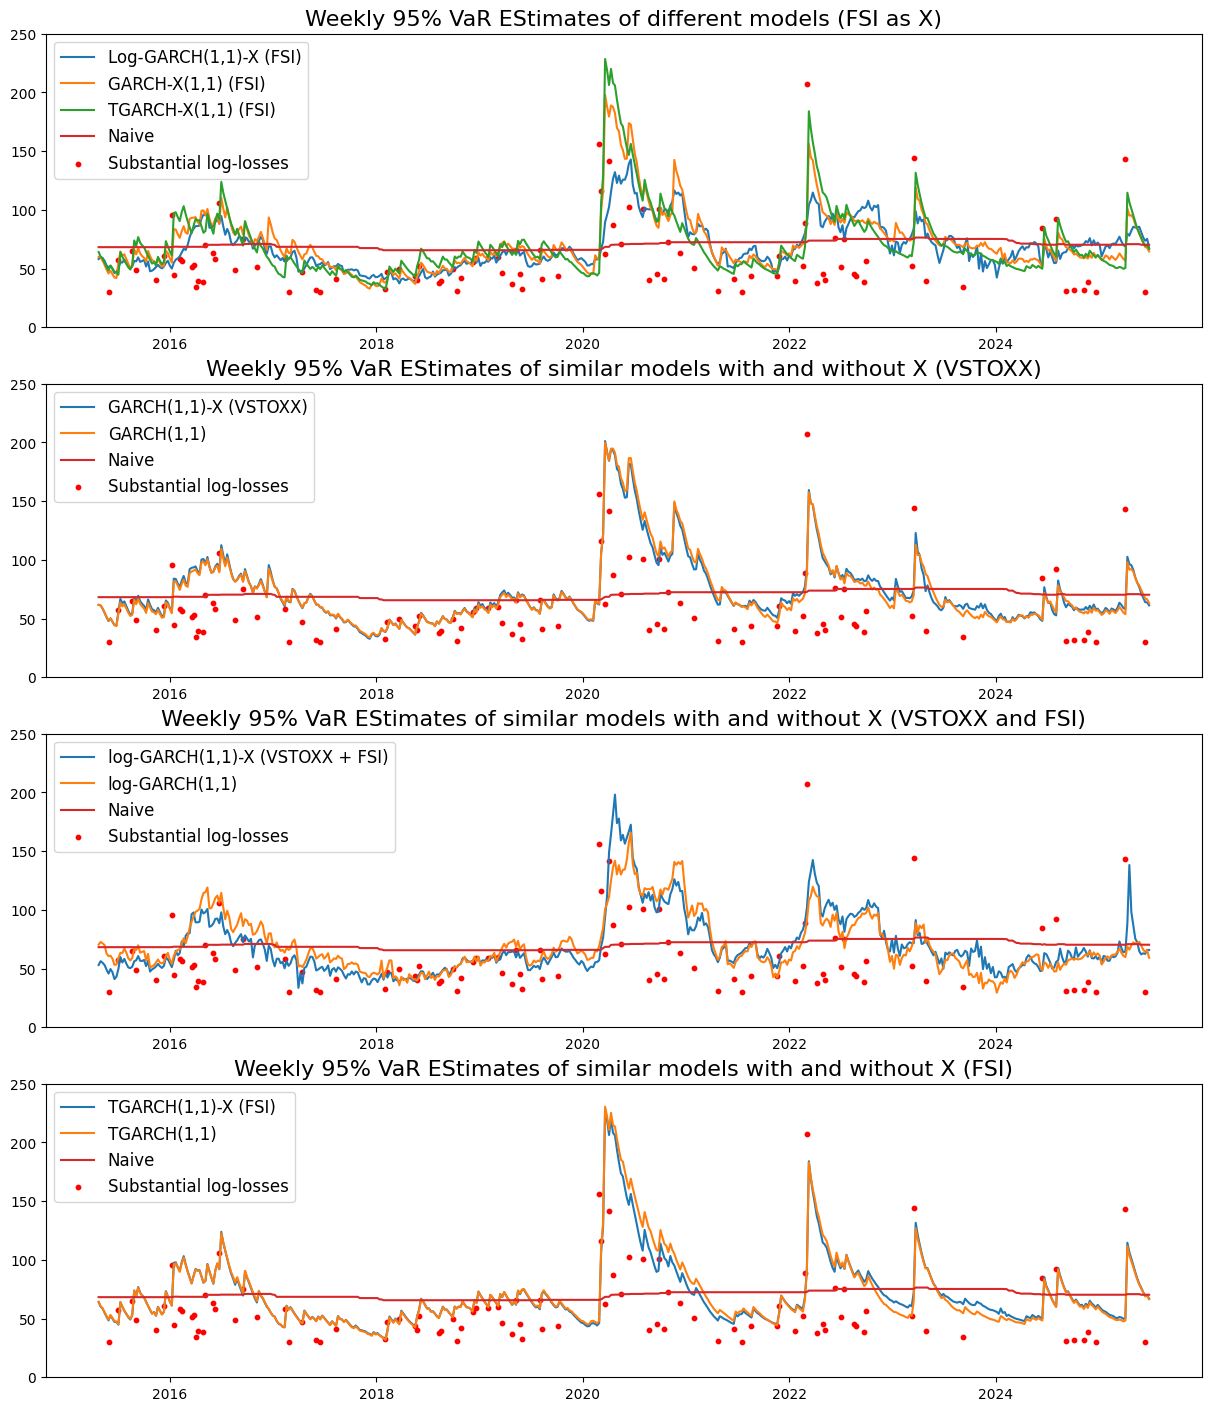

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index[T:H], VaR_Log_GARCHX_FSI, label='Log-GARCH(1,1)-X (FSI)')
axs[0].plot(combined.index[T:H], VaR_GARCHX_FSI, label='GARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], VaR_TGARCHX_FSI, label='TGARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[0].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[0].legend(loc="upper left", fontsize=12)
axs[0].set_title('Weekly 95% VaR EStimates of different models (FSI as X)', fontsize=16)
axs[0].set_ylim(0, 250)


axs[1].plot(combined.index[T:H], VaR_GARCHX_VSTOXX, label='GARCH(1,1)-X (VSTOXX)')
axs[1].plot(combined.index[T:H], VaR_GARCH, label='GARCH(1,1)')
axs[1].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[1].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[1].legend(loc="upper left", fontsize=12)
axs[1].set_title('Weekly 95% VaR EStimates of similar models with and without X (VSTOXX)', fontsize=16)
axs[1].set_ylim(0, 250)

axs[2].plot(combined.index[T:H], VaR_Log_GARCHX_FSI_VSTOXX, label='log-GARCH(1,1)-X (VSTOXX + FSI)')
axs[2].plot(combined.index[T:H], VaR_Log_GARCH, label='log-GARCH(1,1)')
axs[2].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[2].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[2].legend(loc="upper left", fontsize=12)
axs[2].set_title('Weekly 95% VaR EStimates of similar models with and without X (VSTOXX and FSI)', fontsize=16)
axs[2].set_ylim(0, 250)

axs[3].plot(combined.index[T:H], VaR_TGARCHX_FSI, label='TGARCH(1,1)-X (FSI)')
axs[3].plot(combined.index[T:H], VaR_TGARCH, label='TGARCH(1,1)')
axs[3].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[3].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[3].legend(loc="upper left", fontsize=12)
axs[3].set_title('Weekly 95% VaR EStimates of similar models with and without X (FSI)', fontsize=16)
axs[3].set_ylim(0, 250)

plt.show()

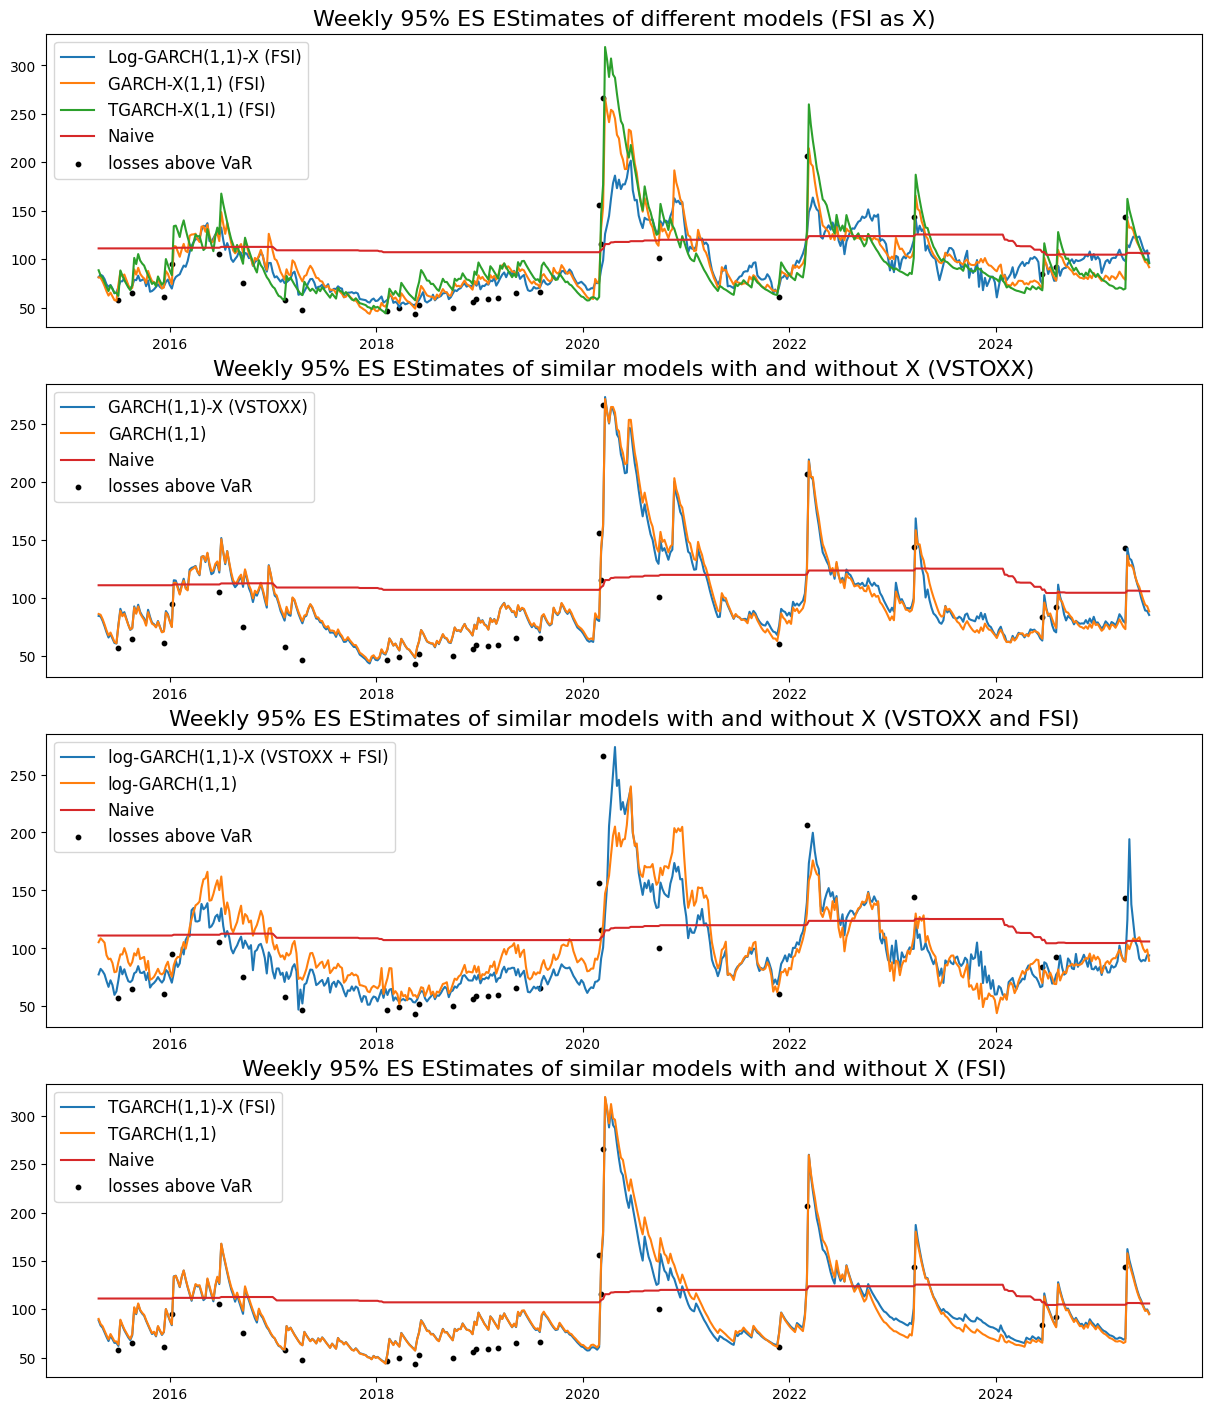

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index[T:H], ES_Log_GARCHX_FSI, label='Log-GARCH(1,1)-X (FSI)')
axs[0].plot(combined.index[T:H], ES_GARCHX_FSI, label='GARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], ES_TGARCHX_FSI, label='TGARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[0].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[0].legend(loc="upper left", fontsize=12)
axs[0].set_title('Weekly 95% ES EStimates of different models (FSI as X)', fontsize=16)
#axs[0].set_ylim(0, 250)


axs[1].plot(combined.index[T:H], ES_GARCHX_VSTOXX, label='GARCH(1,1)-X (VSTOXX)')
axs[1].plot(combined.index[T:H], ES_GARCH, label='GARCH(1,1)')
axs[1].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[1].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[1].legend(loc="upper left", fontsize=12)
axs[1].set_title('Weekly 95% ES EStimates of similar models with and without X (VSTOXX)', fontsize=16)
#axs[1].set_ylim(0, 250)

axs[2].plot(combined.index[T:H], ES_Log_GARCHX_FSI_VSTOXX, label='log-GARCH(1,1)-X (VSTOXX + FSI)')
axs[2].plot(combined.index[T:H], ES_Log_GARCH, label='log-GARCH(1,1)')
axs[2].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[2].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[2].legend(loc="upper left", fontsize=12)
axs[2].set_title('Weekly 95% ES EStimates of similar models with and without X (VSTOXX and FSI)', fontsize=16)
#axs[2].set_ylim(0, 250)

axs[3].plot(combined.index[T:H], ES_TGARCHX_FSI, label='TGARCH(1,1)-X (FSI)')
axs[3].plot(combined.index[T:H], ES_TGARCH, label='TGARCH(1,1)')
axs[3].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[3].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[3].legend(loc="upper left", fontsize=12)
axs[3].set_title('Weekly 95% ES EStimates of similar models with and without X (FSI)', fontsize=16)
#axs[3].set_ylim(0, 250)

plt.show()

In [ ]:
def Scroing_func(r1,r2,Y, alpha):
  S = np.where(Y > r1, 1, 0) * (Y - r1) / np.sqrt(r2) + (1 - alpha) * (r1+r2) / np.sqrt(r2)
  return S

Average elicited VaR from std normal distr: 1.644
The standard deviation of elicited VaR from std normal distr: 0.0663
Average elicited ES from std normal distr: 2.0593
The standard deviation of elicited ES from std normal distr: 0.0766


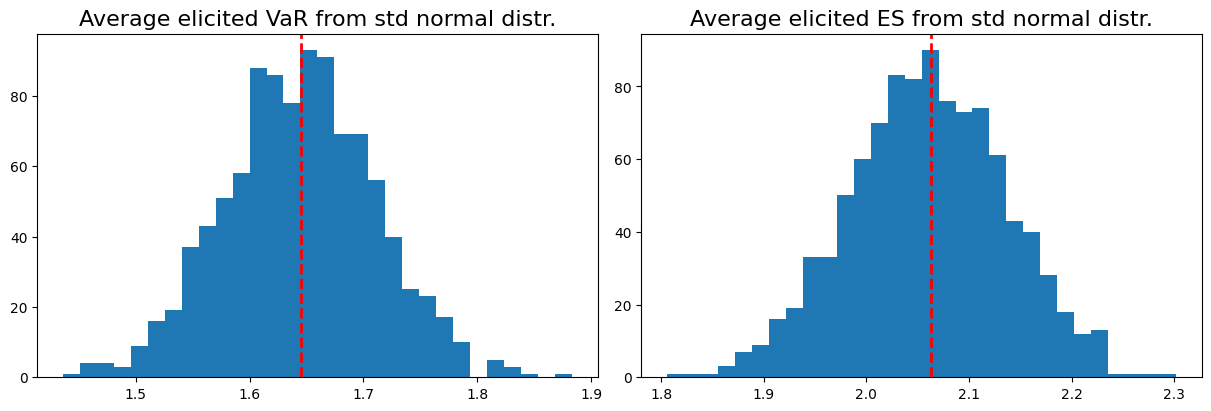

In [ ]:
# sanity check of elicitablity of VaR and ES (target values are 1.645 and 2.063)
np.random.seed(123)
M_O = 10**3 # number of simulted observations per 1 simulation below
M_S = 10**3 # number of simulations, where each simulation minimizes the av_sc function over M_O observations
random_std_N_vec = np.random.normal(0, 1, (M_O,M_S))
results = np.zeros((M_S,2))
x0 = [1, 1]

def av_scores(x,Y, alpha):
  r1, r2 = x
  return np.mean(Scroing_func(r1,r2,Y, alpha))
for m in range(M_S):
  res = minimize(av_scores, x0=[2,1], args=(random_std_N_vec[:,m],0.95))
  results[m,:] = res.x

average_el_var = np.round(np.mean(results[:,0]),4)
average_el_es = np.round(np.mean(results[:,1]),4)
std_el_var = np.round(np.std(results[:,0]),4)
std_el_es = np.round(np.std(results[:,1]),4)
print(f'Average elicited VaR from std normal distr: {average_el_var}')
print(f'The standard deviation of elicited VaR from std normal distr: {std_el_var}')
print(f'Average elicited ES from std normal distr: {average_el_es}')
print(f'The standard deviation of elicited ES from std normal distr: {std_el_es}')

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

axs[0].hist(results[:,0],bins=30)
axs[0].set_title('Average elicited VaR from std normal distr.', fontsize=16)
axs[0].axvline(x=1.645, linestyle='--', linewidth=2, color='r')


axs[1].hist(results[:,1],bins=30)
axs[1].set_title('Average elicited ES from std normal distr.', fontsize=16)
axs[1].axvline(x=2.063, linestyle='--', linewidth=2, color='r')


In [ ]:
av_var = 0
av_es = 0
for name, v_es in VaR_ES.items():
  print(f'Value-at-risk with {name}: {np.round(np.mean(v_es[0]),4)}')
  av_var += np.mean(v_es[0])
av_var = av_var / len(VaR_ES)
print(f'Average Value-at-risk: {av_var}')
print('\n')
for name, v_es in VaR_ES.items():
  print(f'Expected-shortfall with {name}: {np.round(np.mean(v_es[1]),4)}')
  av_es += np.mean(v_es[1])
av_es = av_es / len(VaR_ES)
print(f'Average Expected-shortfall: {av_es}')

Value-at-risk with GARCH(1,1): 71.9456
Value-at-risk with GARCH(1,1)-X (FSI): 72.2856
Value-at-risk with GARCH(1,1)-X (VSTOXX): 72.3976
Value-at-risk with GARCH(1,1)-X (FSI & VSTOXX): 71.5865
Value-at-risk with TGARCH(1,1): 71.1862
Value-at-risk with TGARCH(1,1)-X (FSI): 70.7477
Value-at-risk with TGARCH(1,1)-X (VSTOXX): 70.2458
Value-at-risk with TGARCH(1,1)-X (FSI & VSTOXX): 69.5199
Value-at-risk with Log-GARCH(1,1): 69.7996
Value-at-risk with Log-GARCH(1,1)-X (FSI): 68.1537
Value-at-risk with Log-GARCH(1,1)-X (VSTOXX): 69.8454
Value-at-risk with Log-GARCH(1,1)-X (FSI & VSTOXX): 68.7994
Value-at-risk with Log-GARCH(1,1)-X (FSI & Euribor6m): 63.4269
Value-at-risk with Log-GARCH(1,1)-X (FSI, VSTOXX, Euribor6m): 67.1641
Value-at-risk with Log-GARCH(1,1)-X (VSTOXX & Euribor6m): 70.3183
Value-at-risk with Log-GARCH(1,1)-X (Euribor6m): 70.5552
Value-at-risk with Log-TGARCH(1,1): 64.6537
Value-at-risk with Log-TGARCH(1,1)-X (FSI): 63.8894
Value-at-risk with Log-TGARCH(1,1)-X (VSTOXX): 64.45

In [ ]:
def sample_autocov(u_t, h):
 return 1 / len(u_t) * np.sum(u_t[h:] * u_t[:len(u_t) - h])

def QS_kernel(x):
  if x == 0:
    return 1
  else:
    QS1 = 25/(12 * (np.pi * x)**2)
    QS2 = np.sin(6 * np.pi * x / 5) / (6 * np.pi * x / 5)
    QS3 = np.cos(6 * np.pi * x / 5)
  return QS1 * (QS2 - QS3)


def hac_est_Andrews(d_t, b):
  u_t = d_t - np.mean(d_t)
  gamma_vector = np.zeros((len(u_t)-1,1))
  w = [QS_kernel((l+1)/b) for l in range(len(u_t)-1)]
  for l in range(len(u_t)-1):
    gamma_vector[l] = sample_autocov(u_t, l + 1)
  gamma_0 = sample_autocov(u_t, 0)
  return np.sqrt(gamma_0 + 2 * np.dot(gamma_vector.T, w))

def compute_b(s_t):
  y = np.asarray(s_t, float)[1:]
  x = np.asarray(s_t, float)[:-1]
  rho_hat = sm.OLS(y, sm.add_constant(x)).fit().params[1]
  alpha2 = 4 * rho_hat **2 / (1 - rho_hat) ** 4
  return 1.3221 * (len(s_t) * alpha2) ** 0.2



for name_base, v_es_A in VaR_ES.items():
  for name_A, v_es_B in VaR_ES.items():
    if (name_base != name_A) and (name_base=='Log-TGARCH(1,1)'): #change the base model B only
      d_t = Scroing_func(v_es_A[0], v_es_A[1], -combined['Log Return'][T:H], 0.95) - Scroing_func(v_es_B[0], v_es_B[1], -combined['Log Return'][T:H], 0.95)
      b = compute_b(d_t)
      stat = np.mean(d_t)/(hac_est_Andrews(d_t, b) / np.sqrt(len(d_t)))
      print(f'Model_B: {name_base}, Model_A: {name_A}, Statistic: {np.round(stat,4)}')
      print(f' p-value: {np.round(stats.norm.sf(stat),4)}')



Model_B: Log-TGARCH(1,1), Model_A: GARCH(1,1), Statistic: [0.2649]
 p-value: [0.3956]
Model_B: Log-TGARCH(1,1), Model_A: GARCH(1,1)-X (FSI), Statistic: [0.2011]
 p-value: [0.4203]
Model_B: Log-TGARCH(1,1), Model_A: GARCH(1,1)-X (VSTOXX), Statistic: [0.2912]
 p-value: [0.3854]
Model_B: Log-TGARCH(1,1), Model_A: GARCH(1,1)-X (FSI & VSTOXX), Statistic: [0.2299]
 p-value: [0.4091]
Model_B: Log-TGARCH(1,1), Model_A: TGARCH(1,1), Statistic: [0.3532]
 p-value: [0.362]
Model_B: Log-TGARCH(1,1), Model_A: TGARCH(1,1)-X (FSI), Statistic: [0.376]
 p-value: [0.3535]
Model_B: Log-TGARCH(1,1), Model_A: TGARCH(1,1)-X (VSTOXX), Statistic: [0.442]
 p-value: [0.3292]
Model_B: Log-TGARCH(1,1), Model_A: TGARCH(1,1)-X (FSI & VSTOXX), Statistic: [0.4371]
 p-value: [0.331]
Model_B: Log-TGARCH(1,1), Model_A: Log-GARCH(1,1), Statistic: [0.2541]
 p-value: [0.3997]
Model_B: Log-TGARCH(1,1), Model_A: Log-GARCH(1,1)-X (FSI), Statistic: [0.0753]
 p-value: [0.47]
Model_B: Log-TGARCH(1,1), Model_A: Log-GARCH(1,1)-X (V

In [ ]:
d_t = Scroing_func(VaR_Log_GARCHX_FSI_VSTOXX, ES_Log_GARCHX_FSI_VSTOXX, -combined['Log Return'][T:H], 0.95) - Scroing_func(VaR_Log_GARCH, ES_Log_GARCH, -combined['Log Return'][T:H], 0.95)
def sample_autocov(u_t, h):
 return 1 / len(u_t) * np.sum(u_t[h:] * u_t[:len(u_t) - h])

def QS_kernel(x):
  if x == 0:
    return 1
  else:
    QS1 = 25/(12 * (np.pi * x)**2)
    QS2 = np.sin(6 * np.pi * x / 5) / (6 * np.pi * x / 5)
    QS3 = np.cos(6 * np.pi * x / 5)
  return QS1 * (QS2 - QS3)


def hac_est_Andrews(d_t, b):
  u_t = d_t - np.mean(d_t)
  gamma_vector = np.zeros((len(u_t)-1,1))
  w = [QS_kernel((l+1)/b) for l in range(len(u_t)-1)]
  for l in range(len(u_t)-1):
    gamma_vector[l] = sample_autocov(u_t, l + 1)
  gamma_0 = sample_autocov(u_t, 0)
  return np.sqrt(gamma_0 + 2 * np.dot(gamma_vector.T, w))

def compute_b(s_t):
  y = np.asarray(s_t, float)[1:]
  x = np.asarray(s_t, float)[:-1]
  rho_hat = sm.OLS(y, sm.add_constant(x)).fit().params[1]
  alpha2 = 4 * rho_hat **2 / (1 - rho_hat) ** 4
  return 1.3221 * (len(s_t) * alpha2) ** 0.2

b = compute_b(d_t)



stat = -np.mean(d_t)/(hac_est_Andrews(d_t, b) / np.sqrt(len(d_t)))

print(f'Statistic: {np.round(stat,4)}')
print(f' p-value: {np.round(stats.norm.sf(stat),4)}')



Statistic: [-0.1484]
 p-value: [0.559]


In [ ]:
combined.to_csv('combined.csv')

# **Risk mearures estimation Daily log-losses**

In [ ]:
combined_daily = pd.concat([log_returns, VSTOXX['VSTOXX'], fsi['FSI'], Euribor['Euribor6m']], axis=1)
combined_daily = combined_daily[320:6915] #removing missing periods
exogenous_variables = ['VSTOXX', 'FSI', 'Euribor6m']
combined_daily[exogenous_variables] = combined_daily[exogenous_variables].ffill()
num_rows_with_na = combined_daily['Close'].isna()
combined = combined_daily[~num_rows_with_na]
combined.columns = ['Log Return', 'VSTOXX', 'FSI', 'Euribor6m']
combined.to_csv('combined.csv')
H=len(combined)
T=int(round(H*0.6,0))


Estimate volatility in the different models above.

In [ ]:

vol_GARCH = pd.read_csv('MasterThesis/data/vol/Daily/vol_GARCH.csv')['0']
vol_GARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/Daily/vol_GARCHX_FSI_VSTOXX.csv')['0']

vol_TGARCH = pd.read_csv('MasterThesis/data/vol/Daily/vol_TGARCH.csv')['0']
vol_TGARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/Daily/vol_TGARCHX_FSI_VSTOXX.csv')['0']

def unpack_log_vol(vol__log_name):
  df =  pd.read_csv(vol__log_name)
  vol_log = df['sigma_hat']
  vol_log = pd.concat([pd.Series(vol_log[0:5].mean()), vol_log], ignore_index=True) #imputes first value (was not returned by R package),
  # but does not matter much, just for index consistency
  parameters = df[df.columns[2:]][T-2:-1].reset_index(drop = True)
  parameters.rename(columns={'mu': 'Mu'}, inplace = True)
  return vol_log, parameters


vol_Log_GARCH, parameters_Log_GARCH = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_GARCH.csv')
vol_Log_GARCHX_FSI_VSTOXX, parameters_Log_GARCHX_FSI_VSTOXX = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_GARCHX_FSI_VSTOXX.csv')
vol_Log_GARCHX_FSI_Euribor, parameters_Log_GARCHX_FSI_Euribor = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_GARCHX_FSI_Euribor.csv')
vol_Log_GARCHX_FSI_VSTOXX_Euribor, parameters_Log_GARCHX_FSI_VSTOXX_Euribor = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_GARCHX_FSI_VSTOXX_Euribor.csv')

vol_Log_TGARCH, parameters_Log_TGARCH = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_TGARCH.csv')
vol_Log_TGARCHX_FSI_VSTOXX, parameters_Log_TGARCHX_FSI_VSTOXX = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_TGARCHX_FSI_VSTOXX.csv')
vol_Log_TGARCHX_FSI_Euribor, parameters_Log_TGARCHX_FSI_Euribor = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_TGARCHX_FSI_Euribor.csv')
vol_Log_TGARCHX_FSI_VSTOXX_Euribor, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor = unpack_log_vol('MasterThesis/data/vol/Daily/vol_Log_TGARCHX_FSI_VSTOXX_Euribor.csv')

parameters_GARCH = pd.read_csv('MasterThesis/data/vol/Daily/parameters_GARCH.csv')
parameters_GARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/Daily/parameters_GARCHX_FSI_VSTOXX.csv')

parameters_TGARCH = pd.read_csv('MasterThesis/data/vol/Daily/parameters_TGARCH.csv')
parameters_TGARCHX_FSI_VSTOXX = pd.read_csv('MasterThesis/data/vol/Daily/parameters_TGARCHX_FSI_VSTOXX.csv')

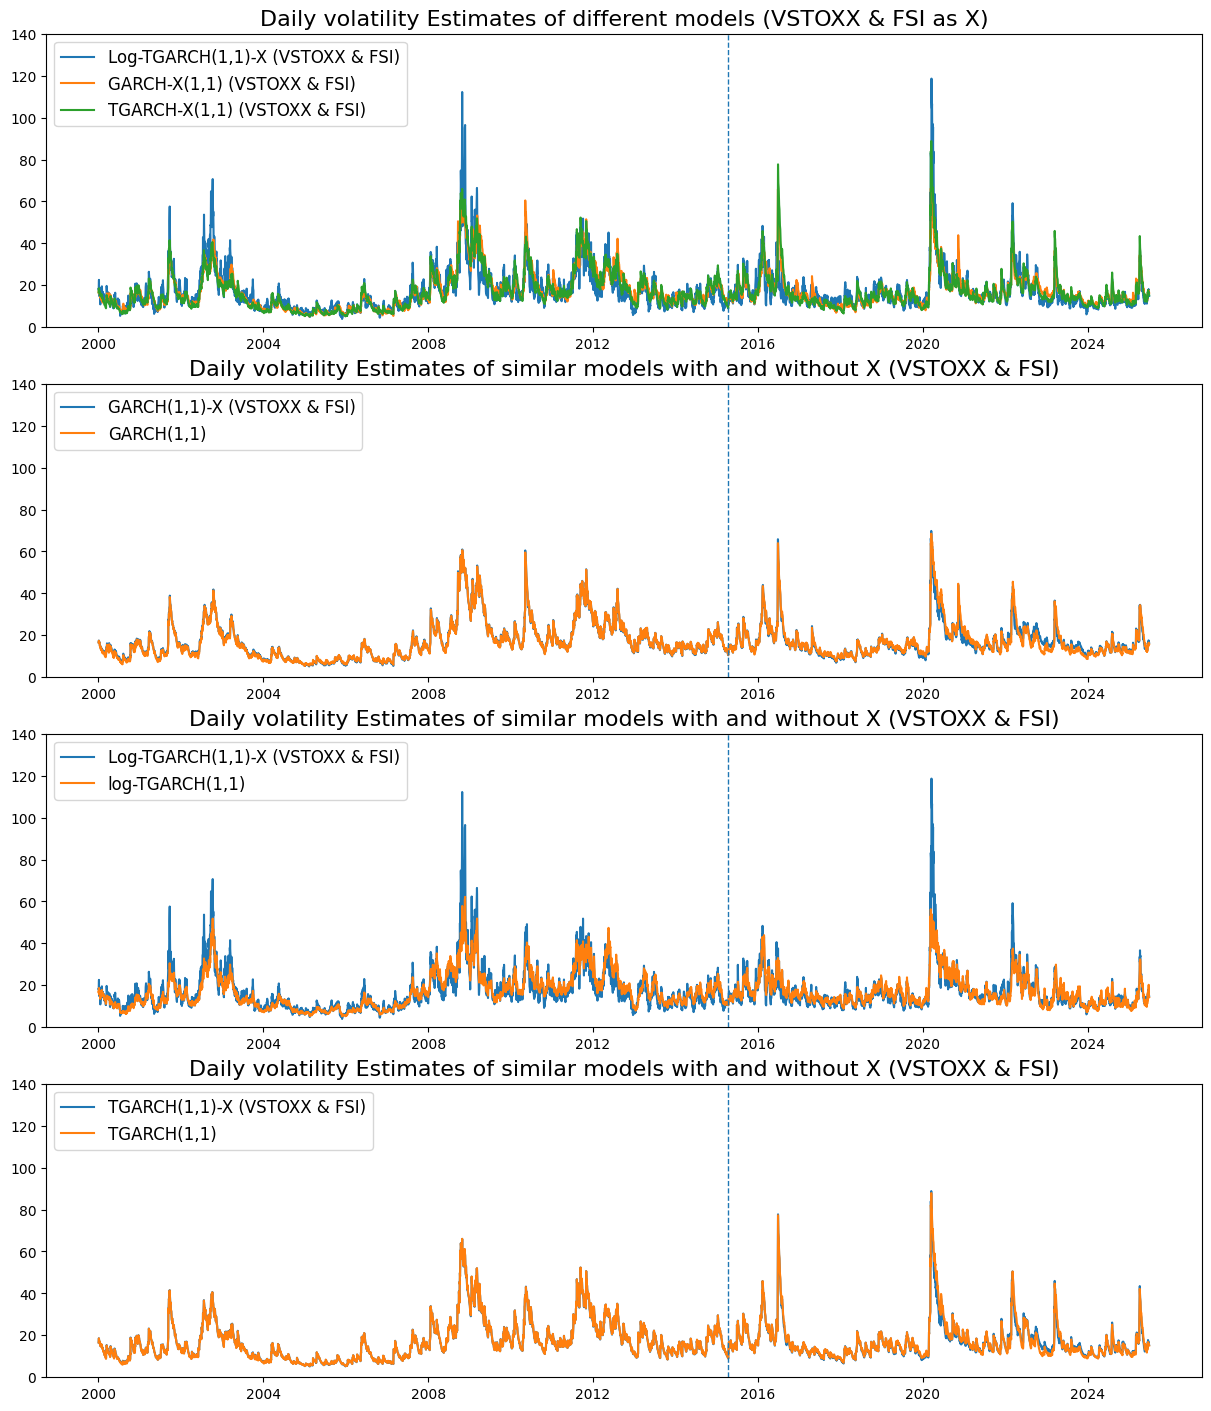

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index, vol_Log_TGARCHX_FSI_VSTOXX, label='Log-TGARCH(1,1)-X (VSTOXX & FSI)')
axs[0].plot(combined.index, vol_GARCHX_FSI_VSTOXX, label='GARCH-X(1,1) (VSTOXX & FSI)')
axs[0].plot(combined.index, vol_TGARCHX_FSI_VSTOXX, label='TGARCH-X(1,1) (VSTOXX & FSI)')
axs[0].legend(loc="upper left", fontsize=12)
axs[0].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[0].set_title('Daily volatility Estimates of different models (VSTOXX & FSI as X)', fontsize=16)
axs[0].set_ylim(0, 140)


axs[1].plot(combined.index, vol_GARCHX_FSI_VSTOXX, label='GARCH(1,1)-X (VSTOXX & FSI)')
axs[1].plot(combined.index, vol_GARCH, label='GARCH(1,1)')
axs[1].legend(loc="upper left", fontsize=12)
axs[1].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[1].set_title('Daily volatility Estimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
axs[1].set_ylim(0, 140)

axs[2].plot(combined.index, vol_Log_TGARCHX_FSI_VSTOXX, label='Log-TGARCH(1,1)-X (VSTOXX & FSI)')
axs[2].plot(combined.index, vol_Log_TGARCH, label='log-TGARCH(1,1)')
axs[2].legend(loc="upper left", fontsize=12)
axs[2].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[2].set_title('Daily volatility Estimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
axs[2].set_ylim(0, 140)

axs[3].plot(combined.index, vol_TGARCHX_FSI_VSTOXX, label='TGARCH(1,1)-X (VSTOXX & FSI)')
axs[3].plot(combined.index, vol_TGARCH, label='TGARCH(1,1)')
axs[3].legend(loc="upper left", fontsize=12)
axs[3].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[3].set_title('Daily volatility Estimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
axs[3].set_ylim(0, 140)

plt.show()

In [ ]:
std_loss_GARCH = np.zeros(H)
std_loss_GARCHX_FSI_VSTOXX = np.zeros(H)

std_loss_TGARCH = np.zeros(H)
std_loss_TGARCHX_FSI_VSTOXX = np.zeros(H)

std_loss_Log_GARCH = np.zeros(H)
std_loss_Log_GARCHX_FSI_VSTOXX = np.zeros(H)
std_loss_Log_GARCHX_FSI_Euribor = np.zeros(H)
std_loss_Log_GARCHX_FSI_VSTOXX_Euribor = np.zeros(H)

std_loss_Log_TGARCH = np.zeros(H)
std_loss_Log_TGARCHX_FSI_VSTOXX = np.zeros(H)
std_loss_Log_TGARCHX_FSI_Euribor = np.zeros(H)
std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor = np.zeros(H)

def st_loss(y, par, vol, start_index, end_index):
  return - (y[start_index:end_index] - par['Mu'][start_index]) / vol[start_index:end_index].to_numpy() # par is already shifted


std_loss_GARCH[0:T] = st_loss(combined['Log Return'], parameters_GARCH, vol_GARCH, 0, T)
std_loss_GARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_GARCHX_FSI_VSTOXX, vol_GARCHX_FSI_VSTOXX, 0, T)

std_loss_TGARCH[0:T] = st_loss(combined['Log Return'], parameters_TGARCH, vol_TGARCH, 0, T)
std_loss_TGARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_TGARCHX_FSI_VSTOXX, vol_TGARCHX_FSI_VSTOXX, 0, T)

std_loss_Log_GARCH[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCH, vol_Log_GARCH, 0, T)
std_loss_Log_GARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX, vol_Log_GARCHX_FSI_VSTOXX, 0, T)
std_loss_Log_GARCHX_FSI_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_FSI_Euribor, vol_Log_GARCHX_FSI_Euribor, 0, T)
std_loss_Log_GARCHX_FSI_VSTOXX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX_Euribor, vol_Log_GARCHX_FSI_VSTOXX_Euribor, 0, T)


std_loss_Log_TGARCH[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCH, vol_Log_TGARCH, 0, T)
std_loss_Log_TGARCHX_FSI_VSTOXX[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX, vol_Log_TGARCHX_FSI_VSTOXX, 0, T)
std_loss_Log_TGARCHX_FSI_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_FSI_Euribor, vol_Log_TGARCHX_FSI_Euribor, 0, T)
std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor[0:T] = st_loss(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX_Euribor, vol_Log_TGARCHX_FSI_VSTOXX_Euribor, 0, T)


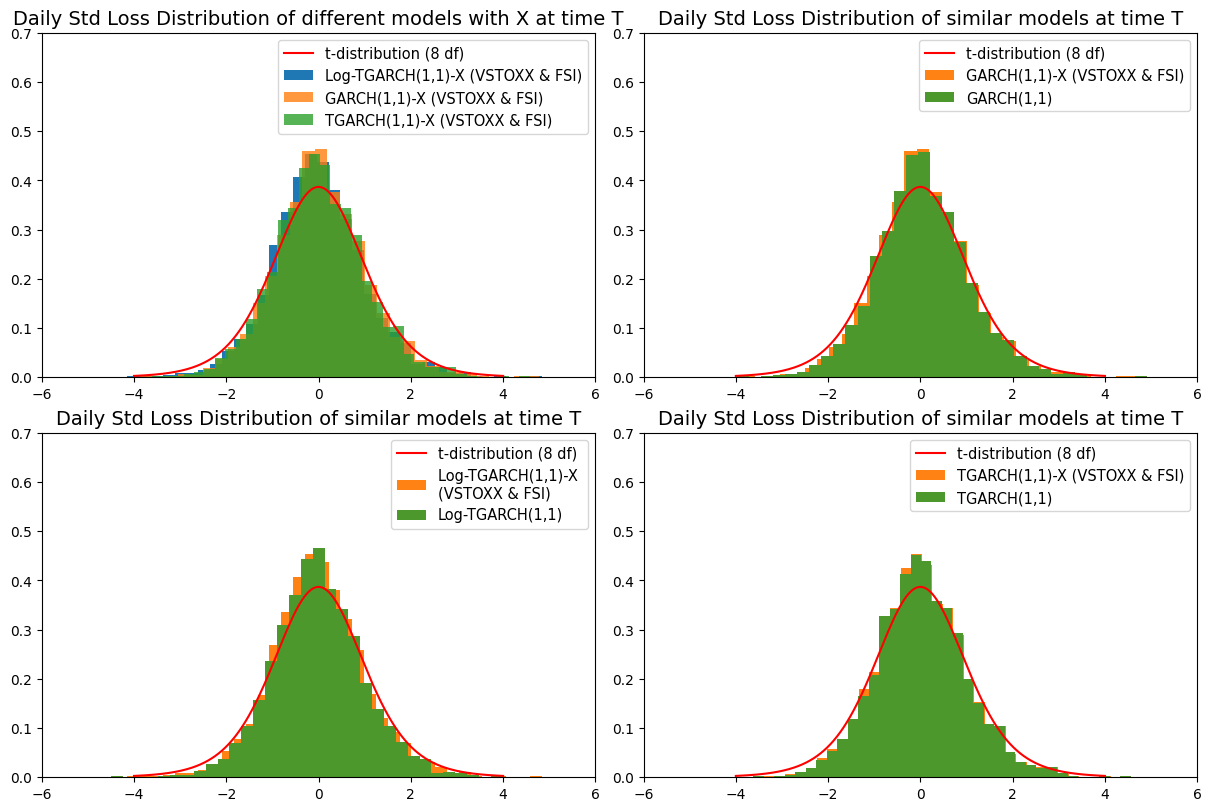

In [ ]:
x_ax_std = np.linspace(-4, 4, 1000)

fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

axs[0,0].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[0,0].hist(std_loss_Log_TGARCHX_FSI_VSTOXX[0:T], bins=40, density=True)
axs[0,0].hist(std_loss_GARCHX_FSI_VSTOXX[0:T], bins=40, alpha=0.8,density=True)
axs[0,0].hist(std_loss_TGARCHX_FSI_VSTOXX[0:T], bins=40, alpha=0.8,density=True)
axs[0,0].legend(['t-distribution (8 df)', 'Log-TGARCH(1,1)-X (VSTOXX & FSI)', 'GARCH(1,1)-X (VSTOXX & FSI)', 'TGARCH(1,1)-X (VSTOXX & FSI)'], loc='upper right', fontsize=10.5)
axs[0,0].set_xlim(-6, 6)
axs[0,0].set_ylim(0, 0.7)
axs[0,0].set_title('Daily Std Loss Distribution of different models with X at time T', fontsize=14)

axs[0,1].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[0,1].hist(std_loss_GARCHX_FSI_VSTOXX[0:T], bins=40, density=True, color='#ff8214')
axs[0,1].hist(std_loss_GARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[0,1].legend(['t-distribution (8 df)', 'GARCH(1,1)-X (VSTOXX & FSI)', 'GARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[0,1].set_xlim(-6, 6)
axs[0,1].set_ylim(0, 0.7)
axs[0,1].set_title('Daily Std Loss Distribution of similar models at time T', fontsize=14)

axs[1,0].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[1,0].hist(std_loss_Log_TGARCHX_FSI_VSTOXX[0:T], bins=40, density=True, color='#ff8214')
axs[1,0].hist(std_loss_Log_TGARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[1,0].legend(['t-distribution (8 df)', 'Log-TGARCH(1,1)-X \n(VSTOXX & FSI)', 'Log-TGARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[1,0].set_xlim(-6, 6)
axs[1,0].set_ylim(0, 0.7)
axs[1,0].set_title('Daily Std Loss Distribution of similar models at time T', fontsize=14)


axs[1,1].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[1,1].hist(std_loss_TGARCHX_FSI_VSTOXX[0:T], bins=40, density=True, color='#ff8214')
axs[1,1].hist(std_loss_TGARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[1,1].legend(['t-distribution (8 df)', 'TGARCH(1,1)-X (VSTOXX & FSI)', 'TGARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[1,1].set_xlim(-6, 6)
axs[1,1].set_ylim(0, 0.7)
axs[1,1].set_title('Daily Std Loss Distribution of similar models at time T', fontsize=14)





# #4d982c - green, #ff8214 - orange, #1f77b4 - blue


plt.show()

In [ ]:

VaR_GARCH = np.zeros(H-T)
VaR_GARCHX_FSI_VSTOXX = np.zeros(H-T)

VaR_TGARCH = np.zeros(H-T)
VaR_TGARCHX_FSI_VSTOXX = np.zeros(H-T)

VaR_Log_GARCH = np.zeros(H-T)
VaR_Log_GARCHX_FSI_VSTOXX = np.zeros(H-T)
VaR_Log_GARCHX_FSI_Euribor = np.zeros(H-T)
VaR_Log_GARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)

VaR_Log_TGARCH = np.zeros(H-T)
VaR_Log_TGARCHX_FSI_VSTOXX = np.zeros(H-T)
VaR_Log_TGARCHX_FSI_Euribor = np.zeros(H-T)
VaR_Log_TGARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)

VaR_naive = np.zeros(H-T)


ES_GARCH = np.zeros(H-T)
ES_GARCHX_FSI_VSTOXX = np.zeros(H-T)

ES_TGARCH = np.zeros(H-T)
ES_TGARCHX_FSI_VSTOXX = np.zeros(H-T)

ES_Log_GARCH = np.zeros(H-T)
ES_Log_GARCHX_FSI_VSTOXX = np.zeros(H-T)
ES_Log_GARCHX_FSI_Euribor = np.zeros(H-T)
ES_Log_GARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)

ES_Log_TGARCH = np.zeros(H-T)
ES_Log_TGARCHX_FSI_VSTOXX = np.zeros(H-T)
ES_Log_TGARCHX_FSI_Euribor = np.zeros(H-T)
ES_Log_TGARCHX_FSI_VSTOXX_Euribor = np.zeros(H-T)

ES_naive = np.zeros(H-T)


def risk_measures(y, par, vol, prev_std_losses, t, t_start):
  mu = par['Mu'][t_start] # t_start are for array already shifted
  new_std_loss = - (y.to_numpy()[t] - mu) / vol[t]
  std_loss = np.append(prev_std_losses, new_std_loss)
  VaR = np.quantile(std_loss[t_start:t], 0.95) * vol[t] - mu
  mask = (std_loss[t_start:t] * vol[t] - mu) > VaR
  ES = (np.mean(std_loss[t_start:t][mask]) * vol[t] - mu)
  return new_std_loss, VaR, ES

for t in range(T,H):

  std_loss_GARCH[t], VaR_GARCH[t-T], ES_GARCH[t-T] = risk_measures(combined['Log Return'], parameters_GARCH, vol_GARCH, std_loss_GARCH, t, t-T)
  std_loss_GARCHX_FSI_VSTOXX[t], VaR_GARCHX_FSI_VSTOXX[t-T], ES_GARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_GARCHX_FSI_VSTOXX, vol_GARCHX_FSI_VSTOXX, std_loss_GARCHX_FSI_VSTOXX, t, t-T)

  std_loss_TGARCH[t], VaR_TGARCH[t-T], ES_TGARCH[t-T] = risk_measures(combined['Log Return'], parameters_TGARCH, vol_TGARCH, std_loss_TGARCH, t, t-T)
  std_loss_TGARCHX_FSI_VSTOXX[t], VaR_TGARCHX_FSI_VSTOXX[t-T], ES_TGARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_TGARCHX_FSI_VSTOXX, vol_TGARCHX_FSI_VSTOXX, std_loss_TGARCHX_FSI_VSTOXX, t, t-T)

  std_loss_Log_GARCH[t], VaR_Log_GARCH[t-T], ES_Log_GARCH[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCH, vol_Log_GARCH, std_loss_Log_GARCH, t, t-T)
  std_loss_Log_GARCHX_FSI_VSTOXX[t], VaR_Log_GARCHX_FSI_VSTOXX[t-T], ES_Log_GARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX, vol_Log_GARCHX_FSI_VSTOXX, std_loss_Log_GARCHX_FSI_VSTOXX, t, t-T)
  std_loss_Log_GARCHX_FSI_Euribor[t], VaR_Log_GARCHX_FSI_Euribor[t-T], ES_Log_GARCHX_FSI_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_FSI_Euribor, vol_Log_GARCHX_FSI_Euribor, std_loss_Log_GARCHX_FSI_Euribor, t, t-T)
  std_loss_Log_GARCHX_FSI_VSTOXX_Euribor[t], VaR_Log_GARCHX_FSI_VSTOXX_Euribor[t-T], ES_Log_GARCHX_FSI_VSTOXX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_GARCHX_FSI_VSTOXX_Euribor, vol_Log_GARCHX_FSI_VSTOXX_Euribor, std_loss_Log_GARCHX_FSI_VSTOXX_Euribor, t, t-T)

  std_loss_Log_TGARCH[t], VaR_Log_TGARCH[t-T], ES_Log_TGARCH[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCH, vol_Log_TGARCH, std_loss_Log_TGARCH, t, t-T)
  std_loss_Log_TGARCHX_FSI_VSTOXX[t], VaR_Log_TGARCHX_FSI_VSTOXX[t-T], ES_Log_TGARCHX_FSI_VSTOXX[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX, vol_Log_TGARCHX_FSI_VSTOXX, std_loss_Log_TGARCHX_FSI_VSTOXX, t, t-T)
  std_loss_Log_TGARCHX_FSI_Euribor[t], VaR_Log_TGARCHX_FSI_Euribor[t-T], ES_Log_TGARCHX_FSI_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_FSI_Euribor, vol_Log_TGARCHX_FSI_Euribor, std_loss_Log_TGARCHX_FSI_Euribor, t, t-T)
  std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor[t], VaR_Log_TGARCHX_FSI_VSTOXX_Euribor[t-T], ES_Log_TGARCHX_FSI_VSTOXX_Euribor[t-T] = risk_measures(combined['Log Return'], parameters_Log_TGARCHX_FSI_VSTOXX_Euribor, vol_Log_TGARCHX_FSI_VSTOXX_Euribor, std_loss_Log_TGARCHX_FSI_VSTOXX_Euribor, t, t-T)

  Naive_losses = -combined['Log Return'][t-T:t]
  VaR_naive[t-T] = np.quantile(Naive_losses, 0.95)
  ES_naive[t-T] = Naive_losses[Naive_losses > VaR_naive[t-T]].mean()

VaR_ES = {
    'GARCH(1,1)' : [VaR_GARCH, ES_GARCH],
    'GARCH(1,1)-X (FSI & VSTOXX)' : [VaR_GARCHX_FSI_VSTOXX, ES_GARCHX_FSI_VSTOXX],
    'TGARCH(1,1)' : [VaR_TGARCH, ES_TGARCH],
    'TGARCH(1,1)-X (FSI & VSTOXX)' : [VaR_TGARCHX_FSI_VSTOXX, ES_TGARCHX_FSI_VSTOXX],
    'Log-GARCH(1,1)' : [VaR_Log_GARCH, ES_Log_GARCH],
    'Log-GARCH(1,1)-X (FSI & VSTOXX)' : [VaR_Log_GARCHX_FSI_VSTOXX, ES_Log_GARCHX_FSI_VSTOXX],
    'Log-GARCH(1,1)-X (FSI & Euribor6m)' : [VaR_Log_GARCHX_FSI_Euribor, ES_Log_GARCHX_FSI_Euribor],
    'Log-GARCH(1,1)-X (FSI, VSTOXX, Euribor6m)' : [VaR_Log_GARCHX_FSI_VSTOXX_Euribor, ES_Log_GARCHX_FSI_VSTOXX_Euribor],
    'Log-TGARCH(1,1)' : [VaR_Log_TGARCH, ES_Log_TGARCH],
    'Log-TGARCH(1,1)-X (FSI & VSTOXX)' : [VaR_Log_TGARCHX_FSI_VSTOXX, ES_Log_TGARCHX_FSI_VSTOXX],
    'Log-TGARCH(1,1)-X (FSI & Euribor6m)' : [VaR_Log_TGARCHX_FSI_Euribor, ES_Log_TGARCHX_FSI_Euribor],
    'Log-TGARCH(1,1)-X (FSI, VSTOXX, Euribor6m)' : [VaR_Log_TGARCHX_FSI_VSTOXX_Euribor, ES_Log_TGARCHX_FSI_VSTOXX_Euribor],
    'Naive' : [VaR_naive , ES_naive]
}




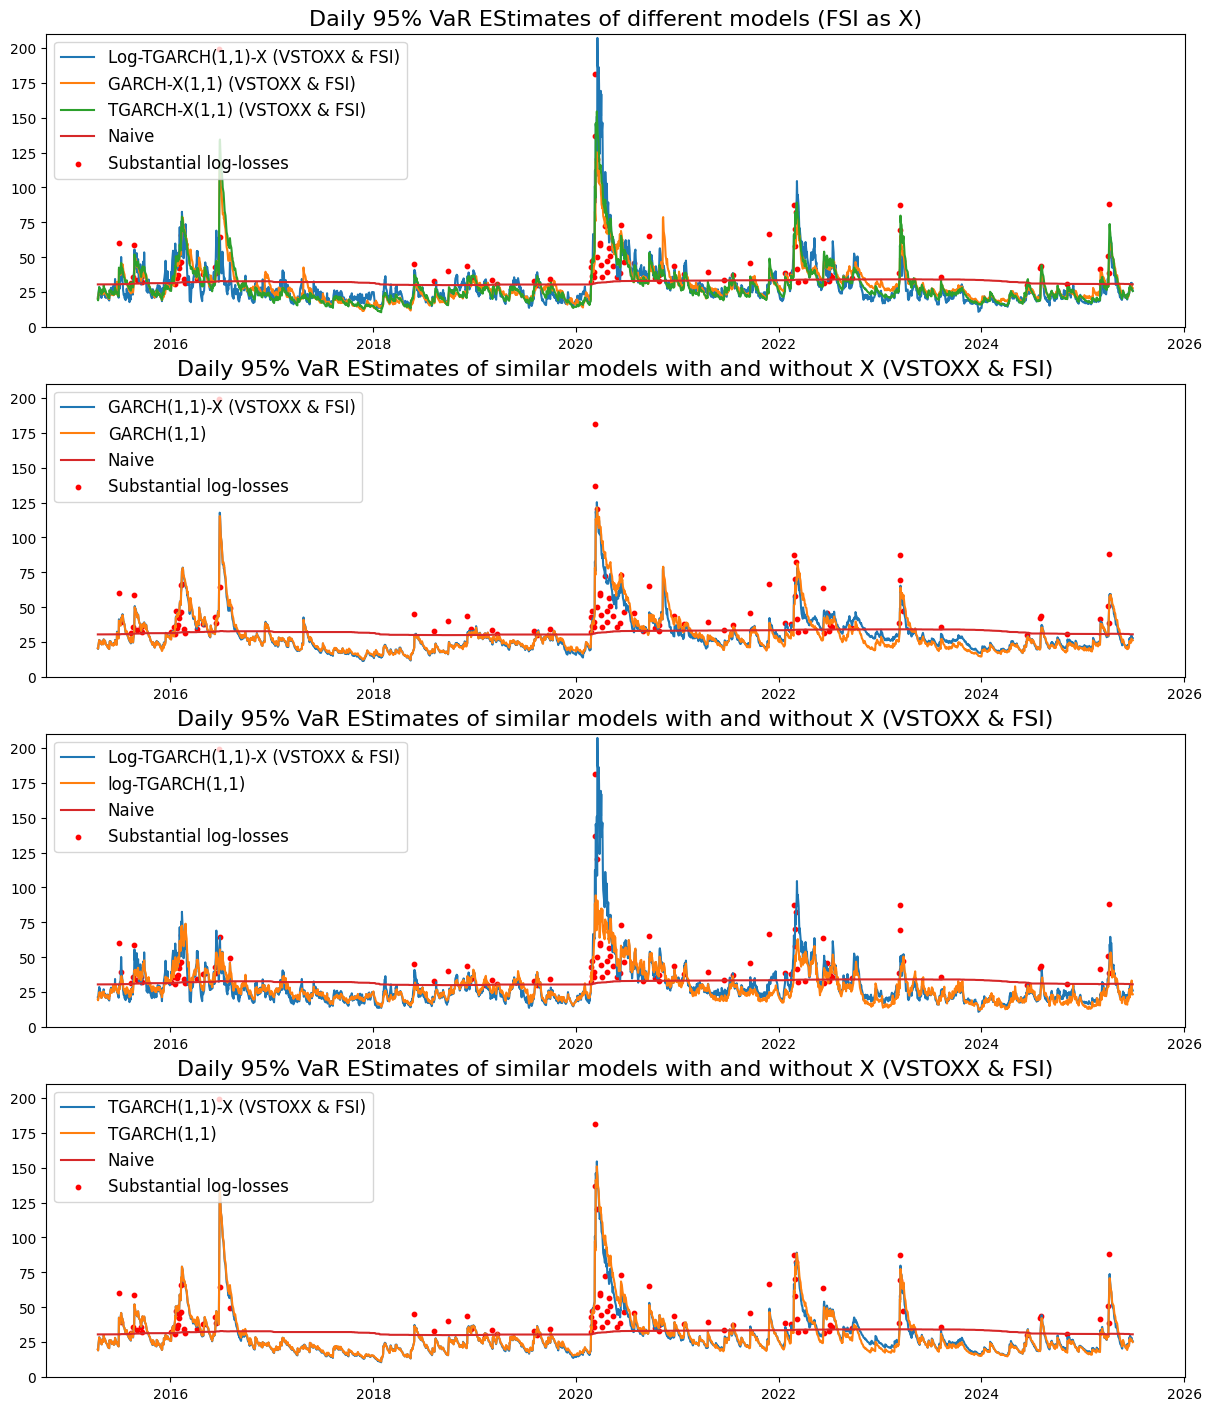

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index[T:H], VaR_Log_TGARCHX_FSI_VSTOXX, label='Log-TGARCH(1,1)-X (VSTOXX & FSI)')
axs[0].plot(combined.index[T:H], VaR_GARCHX_FSI_VSTOXX, label='GARCH-X(1,1) (VSTOXX & FSI)')
axs[0].plot(combined.index[T:H], VaR_TGARCHX_FSI_VSTOXX, label='TGARCH-X(1,1) (VSTOXX & FSI)')
axs[0].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[0].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[0].legend(loc="upper left", fontsize=12)
axs[0].set_title('Daily 95% VaR EStimates of different models (FSI as X)', fontsize=16)
axs[0].set_ylim(0, 210)


axs[1].plot(combined.index[T:H], VaR_GARCHX_FSI_VSTOXX, label='GARCH(1,1)-X (VSTOXX & FSI)')
axs[1].plot(combined.index[T:H], VaR_GARCH, label='GARCH(1,1)')
axs[1].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[1].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[1].legend(loc="upper left", fontsize=12)
axs[1].set_title('Daily 95% VaR EStimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
axs[1].set_ylim(0, 210)

axs[2].plot(combined.index[T:H], VaR_Log_TGARCHX_FSI_VSTOXX, label='Log-TGARCH(1,1)-X (VSTOXX & FSI)')
axs[2].plot(combined.index[T:H], VaR_Log_TGARCH, label='log-TGARCH(1,1)')
axs[2].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[2].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[2].legend(loc="upper left", fontsize=12)
axs[2].set_title('Daily 95% VaR EStimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
axs[2].set_ylim(0, 210)

axs[3].plot(combined.index[T:H], VaR_TGARCHX_FSI_VSTOXX, label='TGARCH(1,1)-X (VSTOXX & FSI)')
axs[3].plot(combined.index[T:H], VaR_TGARCH, label='TGARCH(1,1)')
axs[3].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[3].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[3].legend(loc="upper left", fontsize=12)
axs[3].set_title('Daily 95% VaR EStimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
axs[3].set_ylim(0, 210)

plt.show()

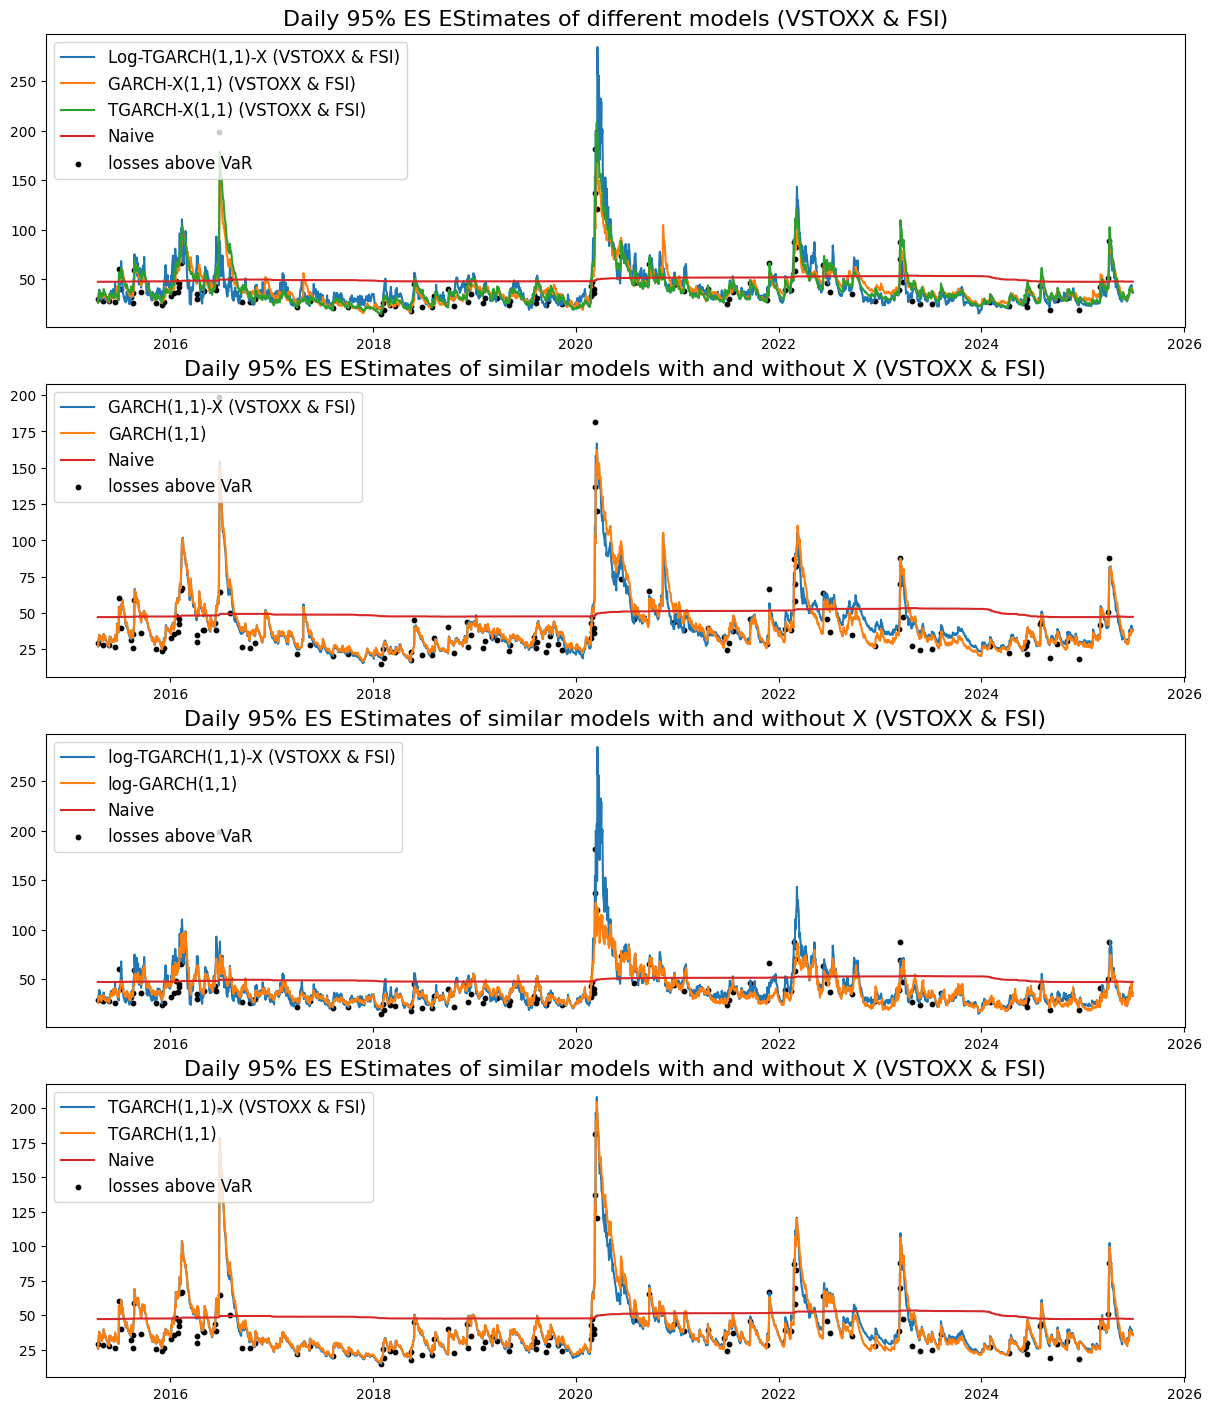

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index[T:H], ES_Log_TGARCHX_FSI_VSTOXX, label='Log-TGARCH(1,1)-X (VSTOXX & FSI)')
axs[0].plot(combined.index[T:H], ES_GARCHX_FSI_VSTOXX, label='GARCH-X(1,1) (VSTOXX & FSI)')
axs[0].plot(combined.index[T:H], ES_TGARCHX_FSI_VSTOXX, label='TGARCH-X(1,1) (VSTOXX & FSI)')
axs[0].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[0].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[0].legend(loc="upper left", fontsize=12)
axs[0].set_title('Daily 95% ES EStimates of different models (VSTOXX & FSI)', fontsize=16)
#axs[0].set_ylim(0, 250)


axs[1].plot(combined.index[T:H], ES_GARCHX_FSI_VSTOXX, label='GARCH(1,1)-X (VSTOXX & FSI)')
axs[1].plot(combined.index[T:H], ES_GARCH, label='GARCH(1,1)')
axs[1].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[1].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[1].legend(loc="upper left", fontsize=12)
axs[1].set_title('Daily 95% ES EStimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
#axs[1].set_ylim(0, 250)

axs[2].plot(combined.index[T:H], ES_Log_TGARCHX_FSI_VSTOXX, label='log-TGARCH(1,1)-X (VSTOXX & FSI)')
axs[2].plot(combined.index[T:H], ES_Log_TGARCH, label='log-GARCH(1,1)')
axs[2].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[2].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[2].legend(loc="upper left", fontsize=12)
axs[2].set_title('Daily 95% ES EStimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
#axs[2].set_ylim(0, 250)

axs[3].plot(combined.index[T:H], ES_TGARCHX_FSI_VSTOXX, label='TGARCH(1,1)-X (VSTOXX & FSI)')
axs[3].plot(combined.index[T:H], ES_TGARCH, label='TGARCH(1,1)')
axs[3].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[3].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[3].legend(loc="upper left", fontsize=12)
axs[3].set_title('Daily 95% ES EStimates of similar models with and without X (VSTOXX & FSI)', fontsize=16)
#axs[3].set_ylim(0, 250)

plt.show()

In [ ]:
def Scroing_func(r1,r2,Y, alpha):
  S = np.where(Y > r1, 1, 0) * (Y - r1) / np.sqrt(r2) + (1 - alpha) * (r1+r2) / np.sqrt(r2)
  return S


In [ ]:

av_var = 0
av_es = 0
for name, v_es in VaR_ES.items():
  print(f'Model: {name}, the average VaR is: {np.round(np.mean(v_es[0]),4)}, the average ES is: {np.round(np.mean(v_es[1]),4)}')
  av_var += np.mean(v_es[0])
  av_es += np.mean(v_es[1])
av_var = av_var / len(VaR_ES)
av_es = av_es / len(VaR_ES)
print(f'Average VaR: {av_var}')
print(f'Average ES: {av_es}')
print('\n')

scores = dict()
for name, v_es in VaR_ES.items():
  av_score = np.round(np.mean(Scroing_func(v_es[0], v_es[1], -combined['Log Return'][T:H], 0.95)),4)
  print(f'Average Score {name}: {av_score}')
  scores[name] = av_score

print('\n')
print('Sorted:')
print('\n')
ranked_scores = sorted(scores.items(), key=lambda s: s[1])

for name, score in ranked_scores:
  #print(f'Average Score {name}: {score}')
  print(f'Model: {name}, Score: {score}, Penalty: {np.round(score*np.sqrt(av_es)*10,2)}')

Model: GARCH(1,1), the average VaR is: 30.3152, the average ES is: 40.5822
Model: GARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 30.3886, the average ES is: 40.4251
Model: TGARCH(1,1), the average VaR is: 29.8624, the average ES is: 40.4032
Model: TGARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 29.7463, the average ES is: 40.1217
Model: Log-GARCH(1,1), the average VaR is: 29.6471, the average ES is: 40.3619
Model: Log-GARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 29.278, the average ES is: 40.0416
Model: Log-GARCH(1,1)-X (FSI & Euribor6m), the average VaR is: 28.7324, the average ES is: 39.2297
Model: Log-GARCH(1,1)-X (FSI, VSTOXX, Euribor6m), the average VaR is: 29.8511, the average ES is: 40.3356
Model: Log-TGARCH(1,1), the average VaR is: 28.4086, the average ES is: 38.3428
Model: Log-TGARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 29.6251, the average ES is: 40.4118
Model: Log-TGARCH(1,1)-X (FSI & Euribor6m), the average VaR is: 28.2757, the average ES is: 38.3863
Model: L

In [ ]:
print(ES_naive.mean())
print(VaR_naive.mean())

49.54079716197425
32.29088826272862


In [ ]:
def sample_autocov(u_t, h):
 return 1 / len(u_t) * np.sum(u_t[h:] * u_t[:len(u_t) - h])

def QS_kernel(x):
  if x == 0:
    return 1
  else:
    QS1 = 25/(12 * (np.pi * x)**2)
    QS2 = np.sin(6 * np.pi * x / 5) / (6 * np.pi * x / 5)
    QS3 = np.cos(6 * np.pi * x / 5)
  return QS1 * (QS2 - QS3)


def hac_est_Andrews(d_t, b):
  u_t = d_t - np.mean(d_t)
  gamma_vector = np.zeros((len(u_t)-1,1))
  w = [QS_kernel((l+1)/b) for l in range(len(u_t)-1)]
  for l in range(len(u_t)-1):
    gamma_vector[l] = sample_autocov(u_t, l + 1)
  gamma_0 = sample_autocov(u_t, 0)
  return np.sqrt(gamma_0 + 2 * np.dot(gamma_vector.T, w))

def compute_b(s_t):
  y = np.asarray(s_t, float)[1:]
  x = np.asarray(s_t, float)[:-1]
  rho_hat = sm.OLS(y, sm.add_constant(x)).fit().params[1]
  alpha2 = 4 * rho_hat **2 / (1 - rho_hat) ** 4
  return 1.3221 * (len(s_t) * alpha2) ** 0.2



for name_base, v_es_A in VaR_ES.items():
  for name_A, v_es_B in VaR_ES.items():
    if (name_base != name_A) and (name_base=='Naive'): #change the base model B only
      d_t = Scroing_func(v_es_A[0], v_es_A[1], -combined['Log Return'][T:H], 0.95) - Scroing_func(v_es_B[0], v_es_B[1], -combined['Log Return'][T:H], 0.95)
      b = compute_b(d_t)
      stat = np.mean(d_t)/(hac_est_Andrews(d_t, b) / np.sqrt(len(d_t)))
      print(f'Model_B: {name_base}, Model_A: {name_A}, Statistic: {np.round(stat,4)}')
      print(f' p-value: {np.round(stats.norm.sf(stat),4)}')



# d_t = Scroing_func(VaR_Log_GARCHX_FSI_VSTOXX, ES_Log_GARCHX_FSI_VSTOXX, -combined['Log Return'][T:H], 0.95) - Scroing_func(VaR_Log_GARCH, ES_Log_GARCH, -combined['Log Return'][T:H], 0.95)
# b = compute_b(d_t)



# stat = -np.mean(d_t)/(hac_est_Andrews(d_t, b) / np.sqrt(len(d_t)))

# print(f'Statistic: {np.round(stat,4)}')
# print(f' p-value: {np.round(stats.norm.sf(stat),4)}')


Model_B: Naive, Model_A: GARCH(1,1), Statistic: [2.8838]
 p-value: [0.002]
Model_B: Naive, Model_A: GARCH(1,1)-X (FSI & VSTOXX), Statistic: [3.0414]
 p-value: [0.0012]
Model_B: Naive, Model_A: TGARCH(1,1), Statistic: [4.5859]
 p-value: [0.]
Model_B: Naive, Model_A: TGARCH(1,1)-X (FSI & VSTOXX), Statistic: [5.1698]
 p-value: [0.]
Model_B: Naive, Model_A: Log-GARCH(1,1), Statistic: [2.5836]
 p-value: [0.0049]
Model_B: Naive, Model_A: Log-GARCH(1,1)-X (FSI & VSTOXX), Statistic: [2.9011]
 p-value: [0.0019]
Model_B: Naive, Model_A: Log-GARCH(1,1)-X (FSI & Euribor6m), Statistic: [2.761]
 p-value: [0.0029]
Model_B: Naive, Model_A: Log-GARCH(1,1)-X (FSI, VSTOXX, Euribor6m), Statistic: [2.9842]
 p-value: [0.0014]
Model_B: Naive, Model_A: Log-TGARCH(1,1), Statistic: [4.0571]
 p-value: [0.]
Model_B: Naive, Model_A: Log-TGARCH(1,1)-X (FSI & VSTOXX), Statistic: [4.2727]
 p-value: [0.]
Model_B: Naive, Model_A: Log-TGARCH(1,1)-X (FSI & Euribor6m), Statistic: [3.72]
 p-value: [0.0001]
Model_B: Naive, 

In [ ]:
av_var = 0
av_es = 0
for name, v_es in VaR_ES.items():
  print(f'Model: {name}, the average VaR is: {np.round(np.mean(v_es[0]),4)}, the average ES is: {np.round(np.mean(v_es[1]),4)}')
  av_var += np.mean(v_es[0])
  av_es += np.mean(v_es[1])
av_var = av_var / len(VaR_ES)
av_es = av_es / len(VaR_ES)
print(f'Average VaR: {av_var}')
print(f'Average ES: {av_es}')

Model: GARCH(1,1), the average VaR is: 30.3152, the average ES is: 40.5822
Model: GARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 30.3886, the average ES is: 40.4251
Model: TGARCH(1,1), the average VaR is: 29.8624, the average ES is: 40.4032
Model: TGARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 29.7463, the average ES is: 40.1217
Model: Log-GARCH(1,1), the average VaR is: 29.6471, the average ES is: 40.3619
Model: Log-GARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 29.278, the average ES is: 40.0416
Model: Log-GARCH(1,1)-X (FSI & Euribor6m), the average VaR is: 28.7324, the average ES is: 39.2297
Model: Log-GARCH(1,1)-X (FSI, VSTOXX, Euribor6m), the average VaR is: 29.8511, the average ES is: 40.3356
Model: Log-TGARCH(1,1), the average VaR is: 28.4086, the average ES is: 38.3428
Model: Log-TGARCH(1,1)-X (FSI & VSTOXX), the average VaR is: 29.6251, the average ES is: 40.4118
Model: Log-TGARCH(1,1)-X (FSI & Euribor6m), the average VaR is: 28.2757, the average ES is: 38.3863
Model: L

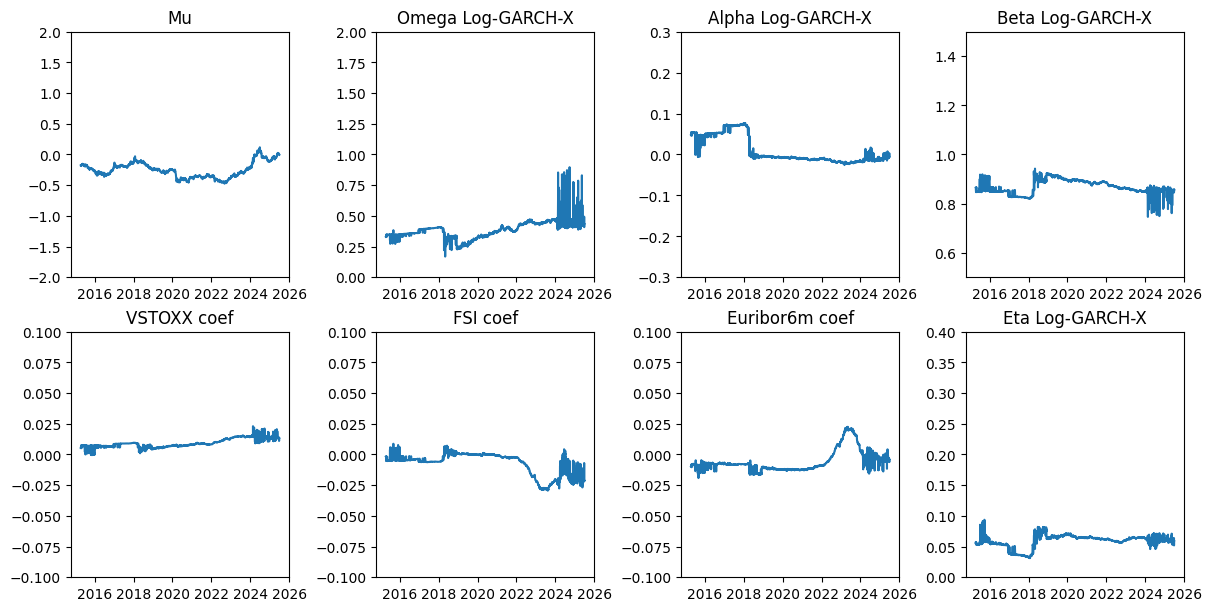

In [ ]:

fig, axs = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
sample_end = int(H*1)
axs[0,0].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,0]);      axs[0, 0].set_title('Mu'); axs[0, 0].set_ylim(-2.0, 2.0)
axs[0,1].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,1]);      axs[0, 1].set_title('Omega Log-GARCH-X'); axs[0, 1].set_ylim(0.0, 2.0)
axs[0,2].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,2]);      axs[0, 2].set_title('Alpha Log-GARCH-X'); axs[0, 2].set_ylim(-0.3, 0.3)
axs[0,3].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,3]);      axs[0, 3].set_title('Beta Log-GARCH-X'); axs[0, 3].set_ylim(0.5, 1.5)
axs[1,0].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,4]);      axs[1, 0].set_title('VSTOXX coef'); axs[1, 0].set_ylim(-0.1, 0.1)
axs[1,1].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,5]);      axs[1, 1].set_title('FSI coef'); axs[1, 1].set_ylim(-0.1, 0.1)
axs[1,2].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,6]);      axs[1, 2].set_title('Euribor6m coef'); axs[1, 2].set_ylim(-0.1, 0.1)
axs[1,3].plot(combined[T:sample_end].index, parameters_Log_TGARCHX_FSI_VSTOXX_Euribor.to_numpy()[:sample_end-T,7]);      axs[1, 3].set_title('Eta Log-GARCH-X'); axs[1, 3].set_ylim(0.0, 0.4)
plt.show()
